In [19]:
#%pip install pandas numpy matplotlib seaborn scikit-learn xgboost imbalanced-learn verifyml interpret

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from interpret.glassbox import ExplainableBoostingClassifier

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, f1_score, recall_score, confusion_matrix,  accuracy_score, precision_score, precision_recall_curve,  average_precision_score, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
import verifyml.model_card_toolkit as mctlib
from verifyml.model_card_toolkit import ModelCardToolkit


## 0. Taula de continguts
- [1. Anàlisi exploratori de dades (EDA)](#1-anàlisi-exploratori-de-dades-eda)
- [2. Preprocessament de dades per model](#2-preprocessament-de-dades-per-model)
    - [2.1 Per a SVM](#21-per-a-svm)
    - [2.2 Per a XGBoost](#22-per-a-xgboost)
    - [2.3 Per a Regressió Logística personalitzada](#23-per-a-regressió-logística-personalitzada)
    - [2.4 Per a Explanable Boosting Machine (EBM)](#24-per-a-explanable-boosting-machine-ebm)
- [3. Model Card](#3-model-card)

## 1. Anàlisi exploratori de dades (EDA)

In [7]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

df = pd.read_csv('trs_train.csv')

print(f"Dimensions del dataset: {df.shape}")
display(df.head())

Dimensions del dataset: (9000, 28)


,patient_id,Age,Sex,Ethnicity,Duration_untreated_psychosis,Family_history,Initial_response,Lymphocyte_count,Neutrophil_count,BMI,...,Polygenic_risk_score,Del_22q11_2_status,IL_17A,CCL23,TWEAK,Ki_whole_striatum,Ki_associative_striatum,SUVRc_whole_striatum,SUVRc_associative_striatum,TRS
0,1,28.0,1,Caucasian,7.5,1,24.7,2.35,NaN,31.2,...,0.330,0,2.76,5.66,4.47,0.01147,0.01082,1.225,1.133,0
1,2,23.0,1,Asian,3.6,1,41.0,2.02,3.34,26.2,...,0.121,0,2.04,2.67,1.93,0.01386,0.01437,1.042,1.502,0
2,3,29.0,1,Caucasian,7.4,0,6.0,NaN,5.38,39.2,...,-0.098,0,1.55,2.31,2.92,0.01589,0.01632,1.728,1.842,0
3,4,36.0,0,Hispanic,5.5,0,43.4,1.60,6.84,31.5,...,0.019,0,1.77,2.37,4.26,0.01178,0.01154,1.399,1.249,0
4,5,23.0,0,Caucasian,4.5,0,86.1,NaN,3.18,29.6,...,-0.049,0,2.11,3.55,3.84,0.01209,0.01171,0.800,1.533,0


Taula amb les estadístiques descriptives de les variables numèriques i categòriques del dataset.

In [8]:
stats_desc = df.describe(include='all').T
stats_desc['missing_rate'] = df.isnull().mean()
display(stats_desc)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,missing_rate
patient_id,9000.0,NaN,NaN,NaN,4500.5,2598.220545,1.0,2250.75,4500.5,6750.25,9000.0,0.000000
Age,9000.0,NaN,NaN,NaN,26.039444,10.011767,13.0,19.0,25.0,31.0,64.0,0.000000
Sex,9000.0,NaN,NaN,NaN,0.576,0.494218,0.0,0.0,1.0,1.0,1.0,0.000000
Ethnicity,9000,4,Caucasian,5408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
Duration_untreated_psychosis,8872.0,NaN,NaN,NaN,19.220548,19.545745,0.3,6.4,12.5,24.3,125.0,0.014222
Family_history,9000.0,NaN,NaN,NaN,0.118778,0.323545,0.0,0.0,0.0,0.0,1.0,0.000000
Initial_response,9000.0,NaN,NaN,NaN,41.840367,30.16023,0.0,10.1,38.2,72.3,100.0,0.000000
Lymphocyte_count,7009.0,NaN,NaN,NaN,1.795761,0.601099,0.5,1.38,1.8,2.2,4.02,0.221222
Neutrophil_count,7015.0,NaN,NaN,NaN,5.014574,1.471581,1.5,4.005,5.02,6.01,9.96,0.220556
BMI,9000.0,NaN,NaN,NaN,28.107556,5.4331,15.0,24.4,28.0,31.7,49.6,0.000000


Desbalanceig de la classe objectiu

Ratio de classes:
TRS
0    0.684667
1    0.315333
Name: proportion, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_18828\2760328015.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TRS', data=df, palette='viridis')


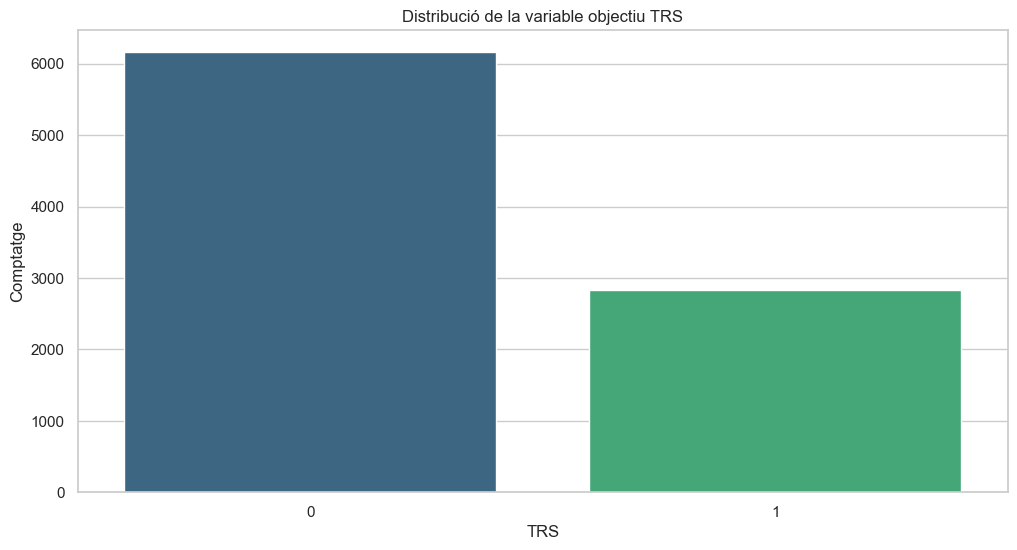

In [9]:
ratio_trs = df['TRS'].value_counts(normalize=True)
print(f"Ratio de classes:\n{ratio_trs}")
plt.figure()
sns.countplot(x='TRS', data=df, palette='viridis')
plt.title('Distribució de la variable objectiu TRS')
plt.xlabel('TRS')
plt.ylabel('Comptatge')
plt.show()

Anàlisi de les variables categòriques en funció de la classe objectiu

['CYP2D6_metabolic_phenotype', 'HLA_DRB1_04_02', 'HLA_B_15_02', 'Family_history', 'Del_22q11_2_status', 'Prior_antipsychotics', 'HLA_A_31_01', 'Sex', 'Ethnicity']


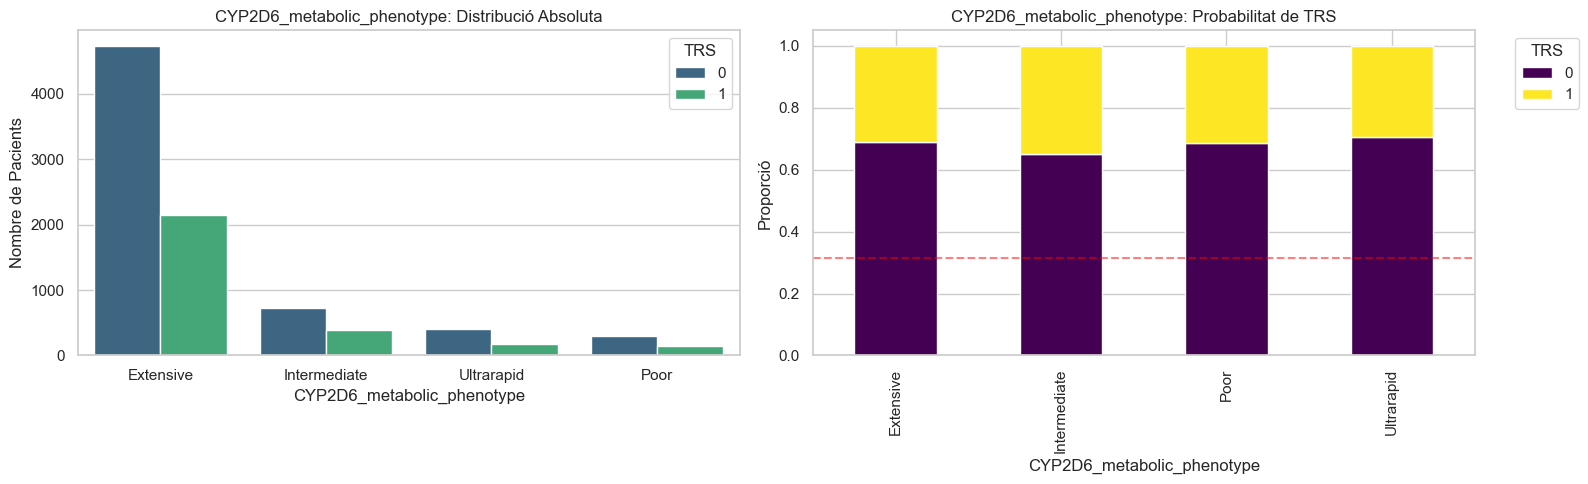

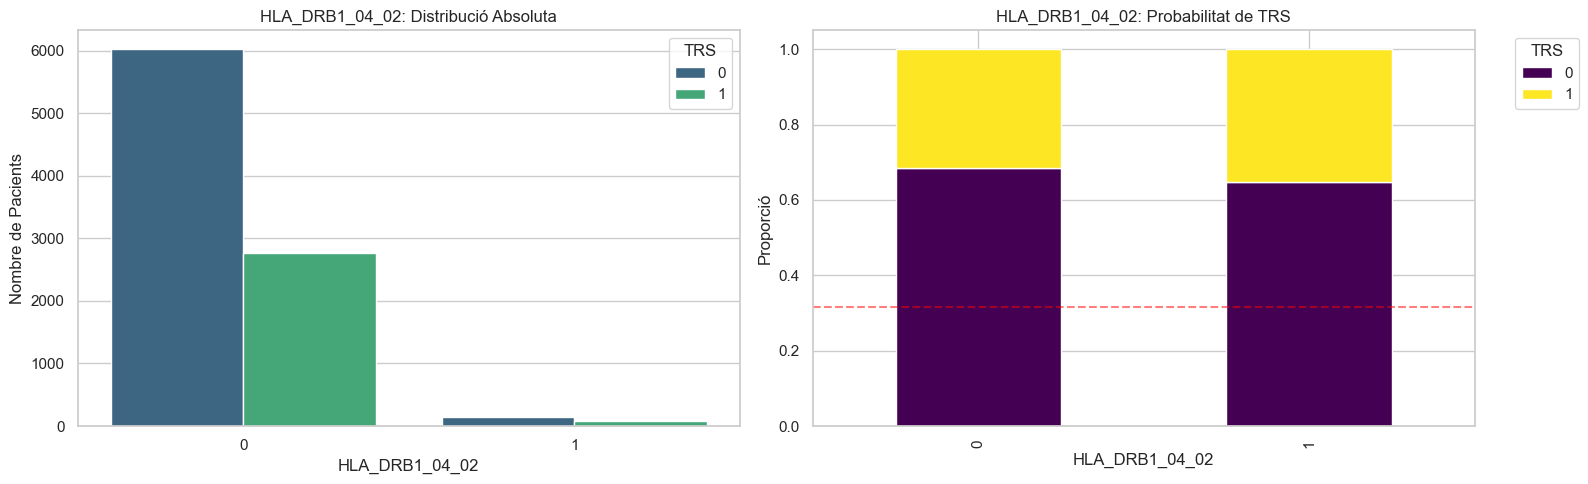

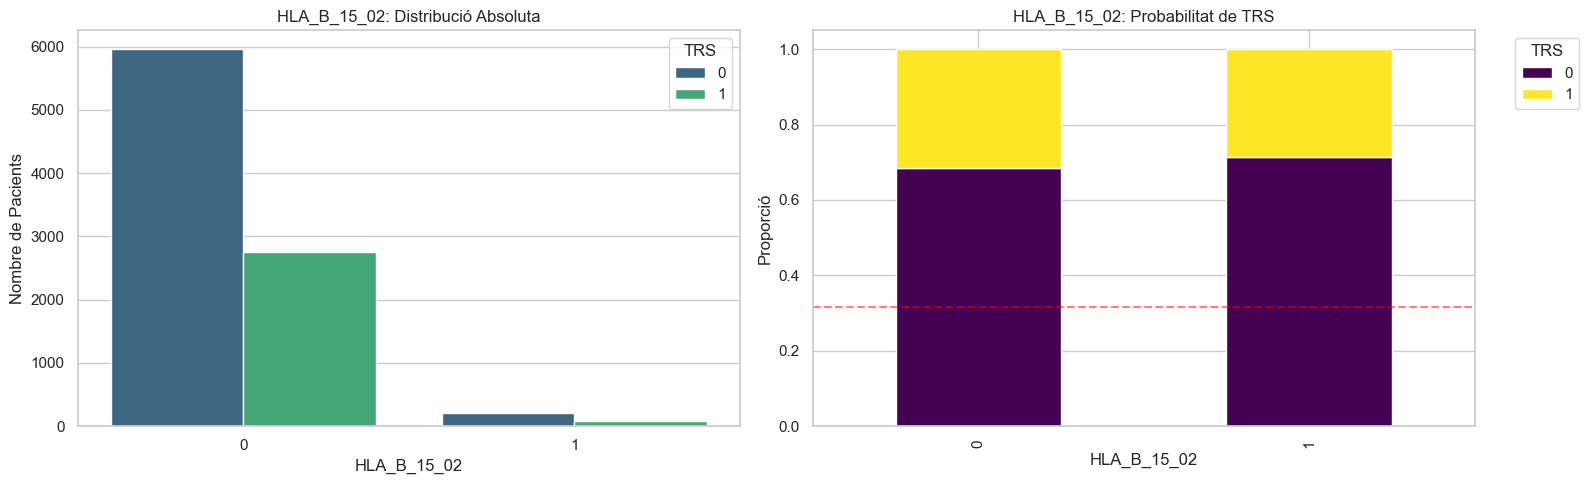

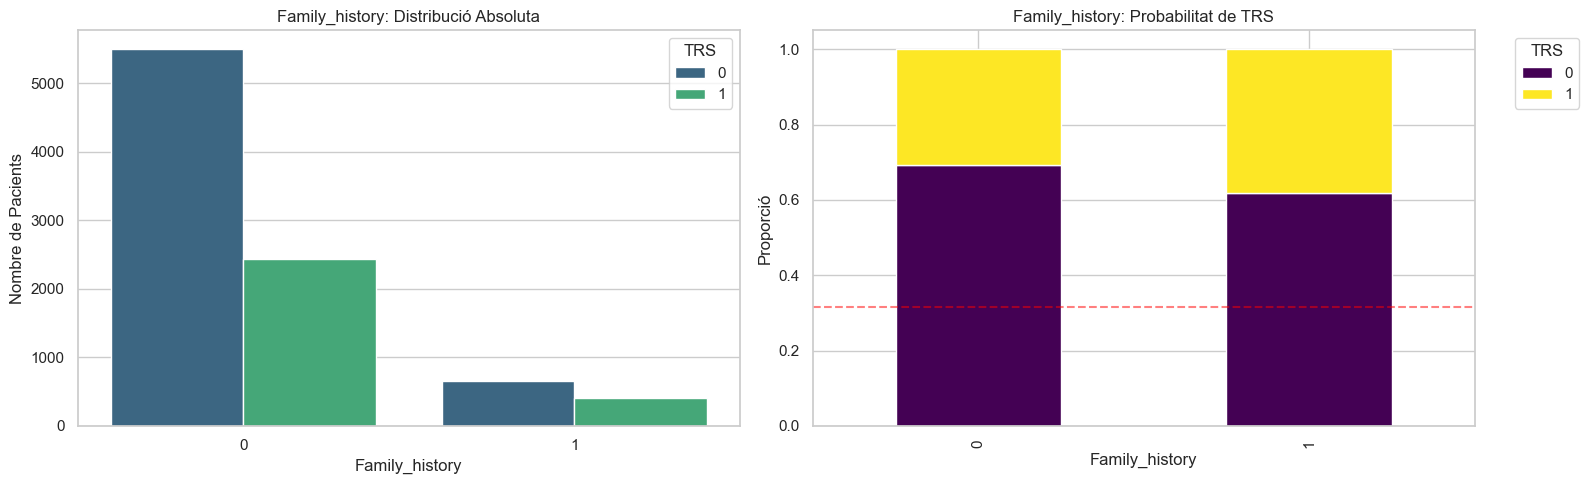

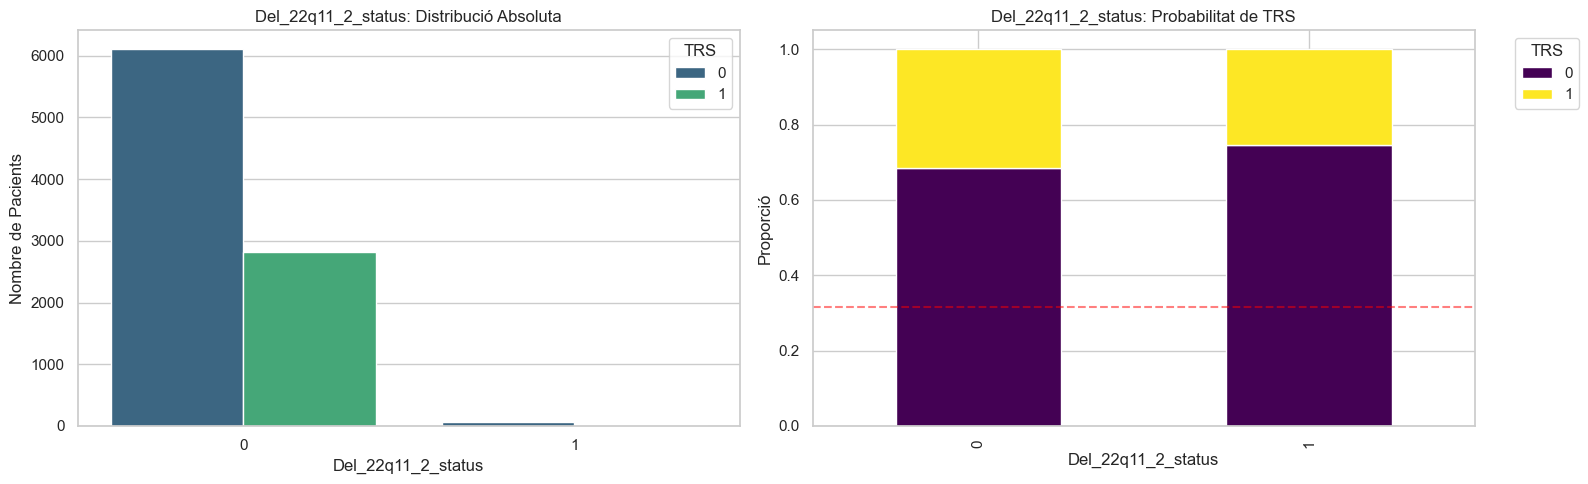

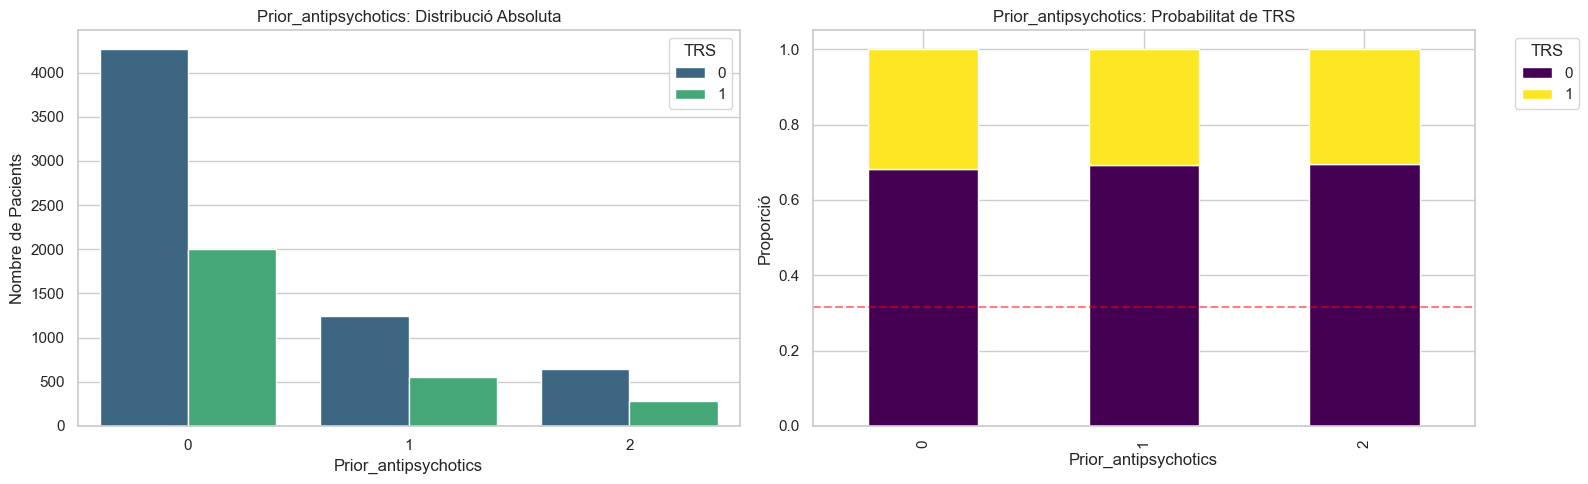

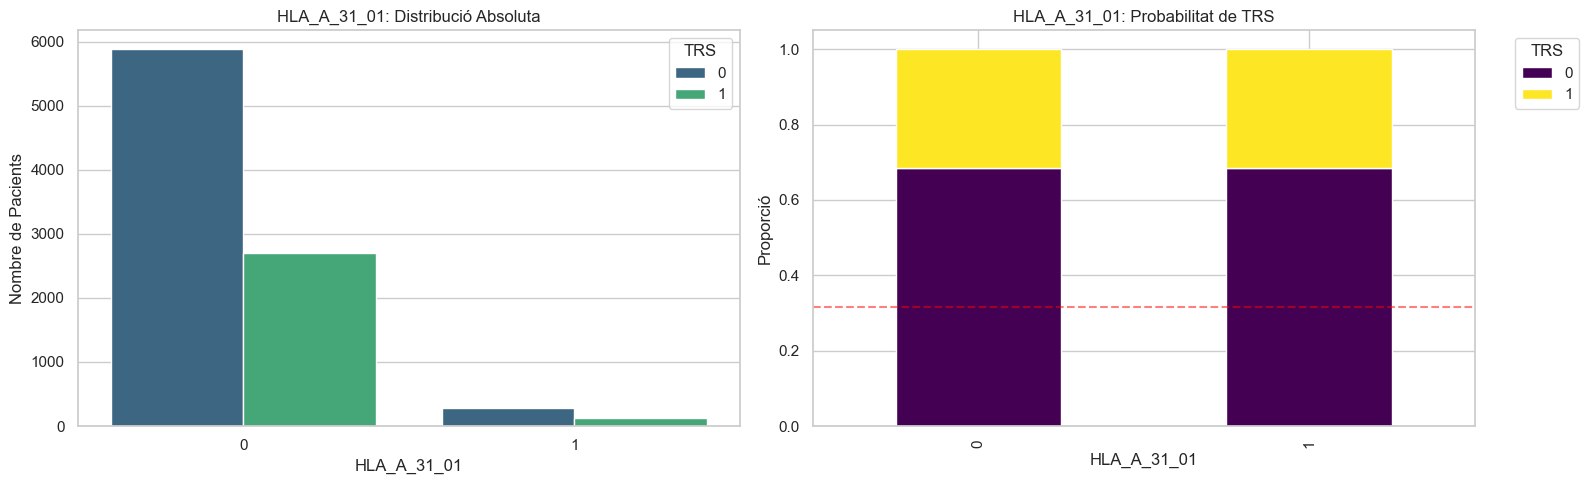

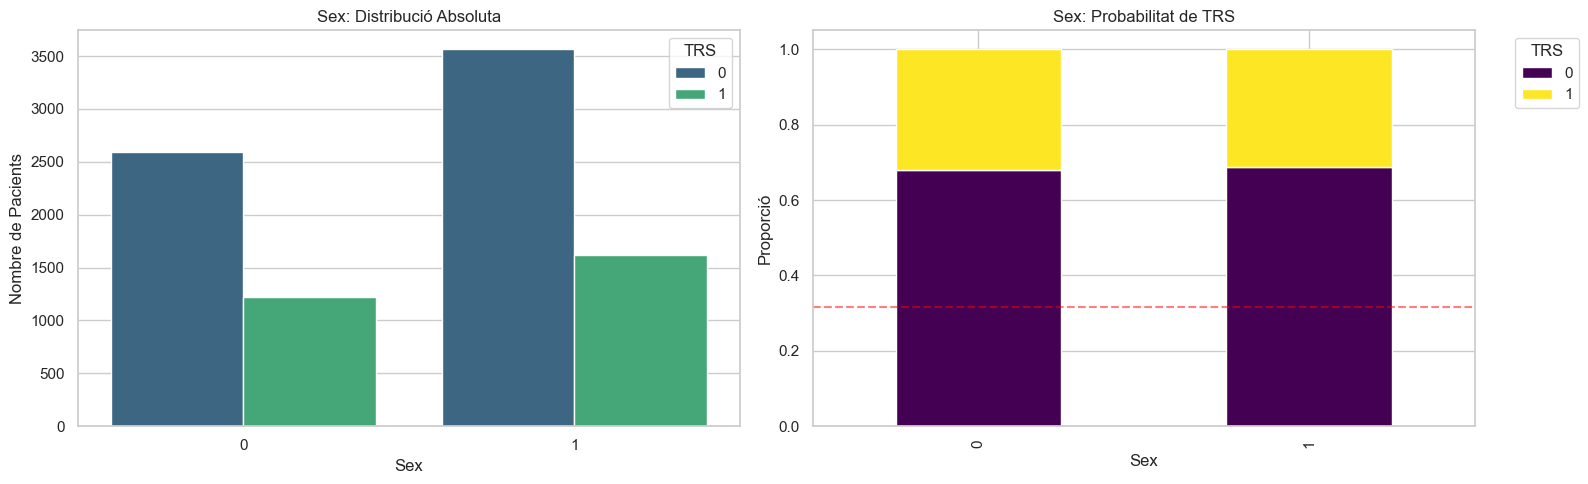

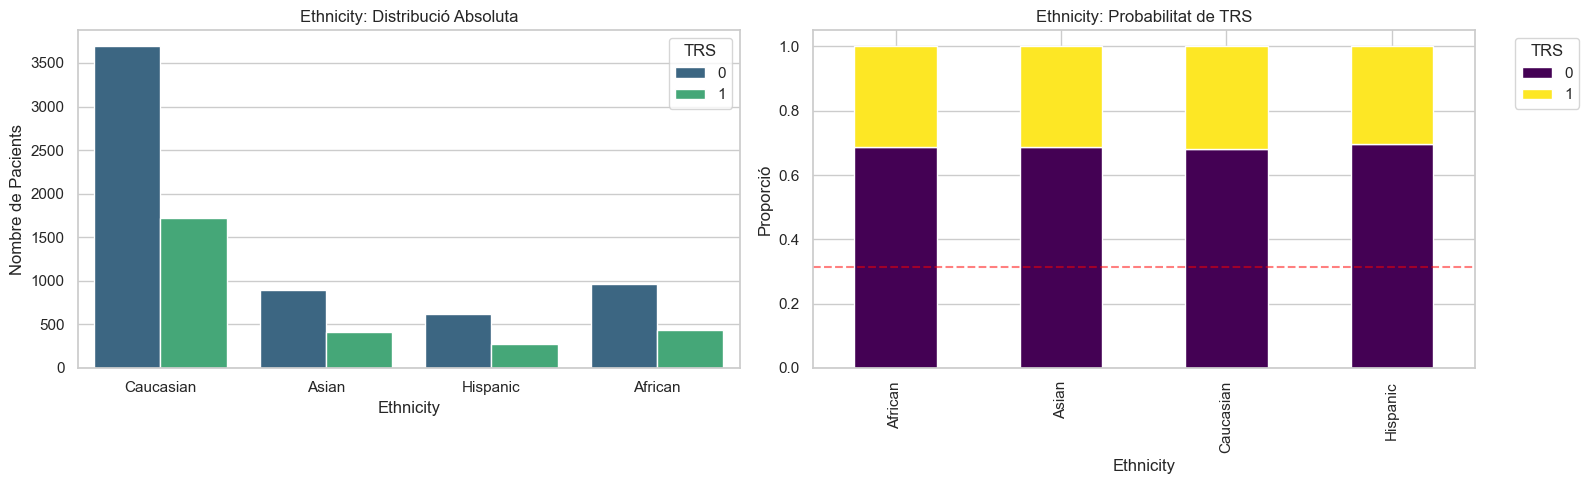

In [13]:

from scipy.stats import chi2_contingency

df = pd.read_csv('trs_train.csv')

# seran categòriques les de text i les numèriques amb pocs valors únics
text_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = df.select_dtypes(include=['number']).columns
discrete_num_cols = [col for col in num_cols if df[col].nunique() < 10]

all_categorical_cols = list(set(text_cols + discrete_num_cols))

if 'TRS' in all_categorical_cols: all_categorical_cols.remove('TRS')
if 'patient_id' in all_categorical_cols: all_categorical_cols.remove('patient_id')

# imprimim les columnes categòriques
print(all_categorical_cols)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 5)


for col in all_categorical_cols:

    # fem chi-quadrat per veure si és significativa
    contingency_table = pd.crosstab(df[col], df['TRS'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    is_significant = True if p_value < 0.05 else False
    if is_significant:
        significance_text = "La variable és significativa per a TRS (p < 0.05)"

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # distribució classe objectiu per categoria
    sns.countplot(data=df, x=col, hue='TRS', ax=axes[0], palette='viridis')
    axes[0].set_title(f'{col}: Distribució Absoluta')
    axes[0].set_ylabel('Nombre de Pacients')
    
    # proporcions per categoria
    props = pd.crosstab(df[col], df['TRS'], normalize='index')
    props.plot(kind='bar', stacked=True, ax=axes[1], colormap='viridis')
    
    axes[1].set_title(f'{col}: Probabilitat de TRS')
    axes[1].set_ylabel('Proporció')
    axes[1].legend(title='TRS', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    #  mitjana global
    global_mean = df['TRS'].mean()
    axes[1].axhline(y=global_mean, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

Anàlisi de la distribució de les variables numèriques.
Els models són sensibles a distribucions no normals, per tant, volem una mesura de Skewness també.

                    Variable  Skewness  Kurtosis                                    Estat
Duration_untreated_psychosis  2.150479  5.323006 🔴 MOLT ASIMÈTRICA (Requereix Log/BoxCox)
                         Age  1.258793  2.065980 🔴 MOLT ASIMÈTRICA (Requereix Log/BoxCox)
  SUVRc_associative_striatum  0.457536 -0.422680                     🟢 NORMAL (Simètrica)
        SUVRc_whole_striatum  0.434121 -0.408815                     🟢 NORMAL (Simètrica)
        Polygenic_risk_score  0.405186  0.323084                     🟢 NORMAL (Simètrica)
     Ki_associative_striatum  0.328552 -0.022675                     🟢 NORMAL (Simètrica)
            Initial_response  0.263114 -1.177505                     🟢 NORMAL (Simètrica)
           Ki_whole_striatum  0.258888 -0.114160                     🟢 NORMAL (Simètrica)
                     Glucose  0.244757 -0.447048                     🟢 NORMAL (Simètrica)
               Triglycerides  0.187324 -0.324556                     🟢 NORMAL (Simètrica)
        Al

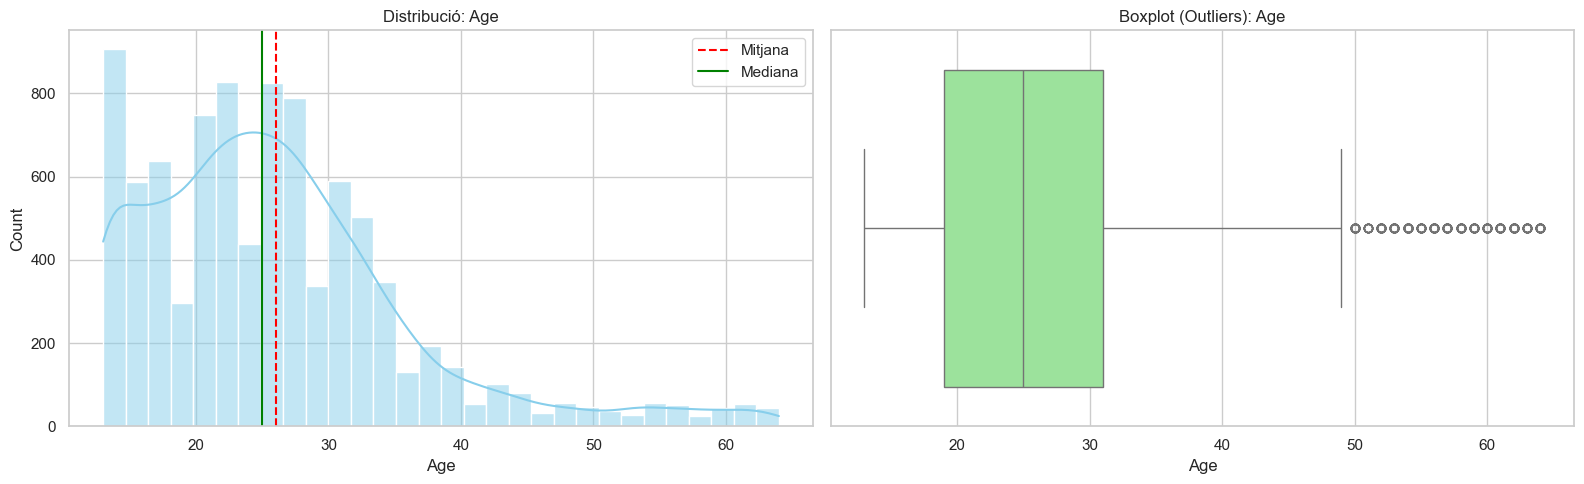

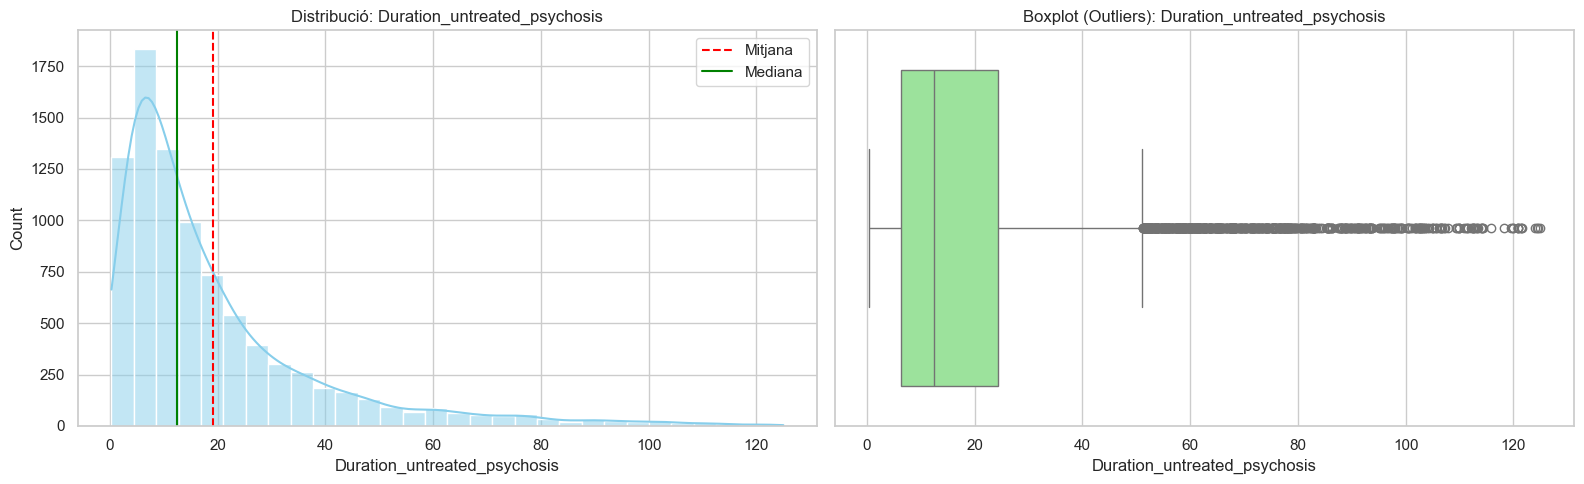

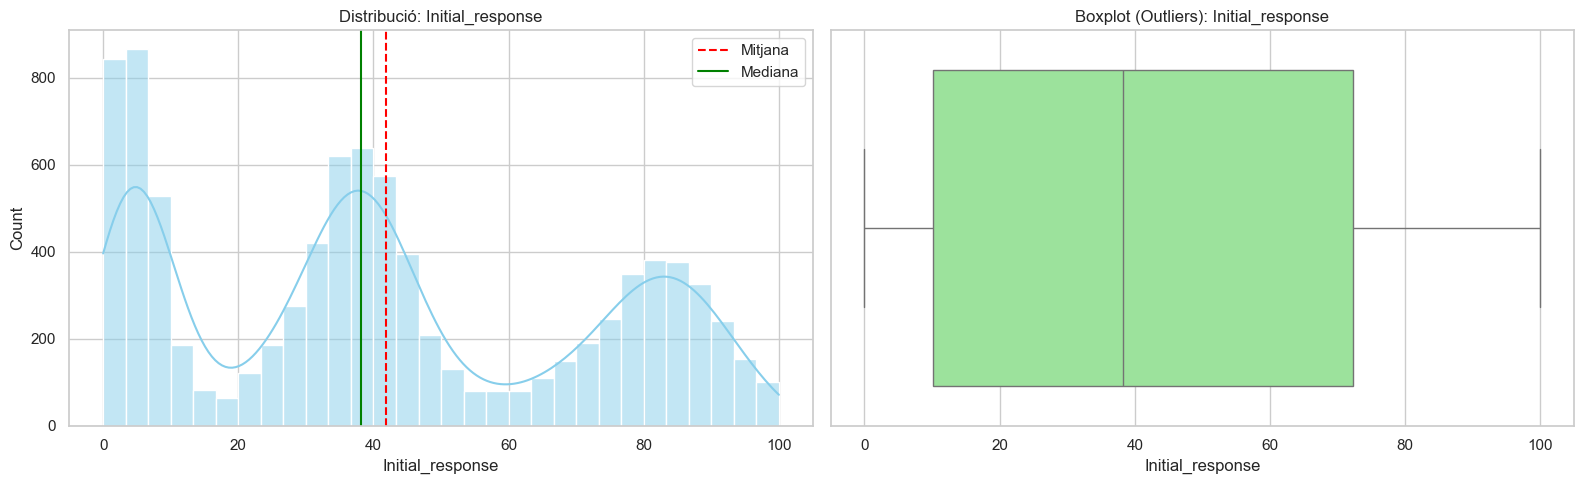

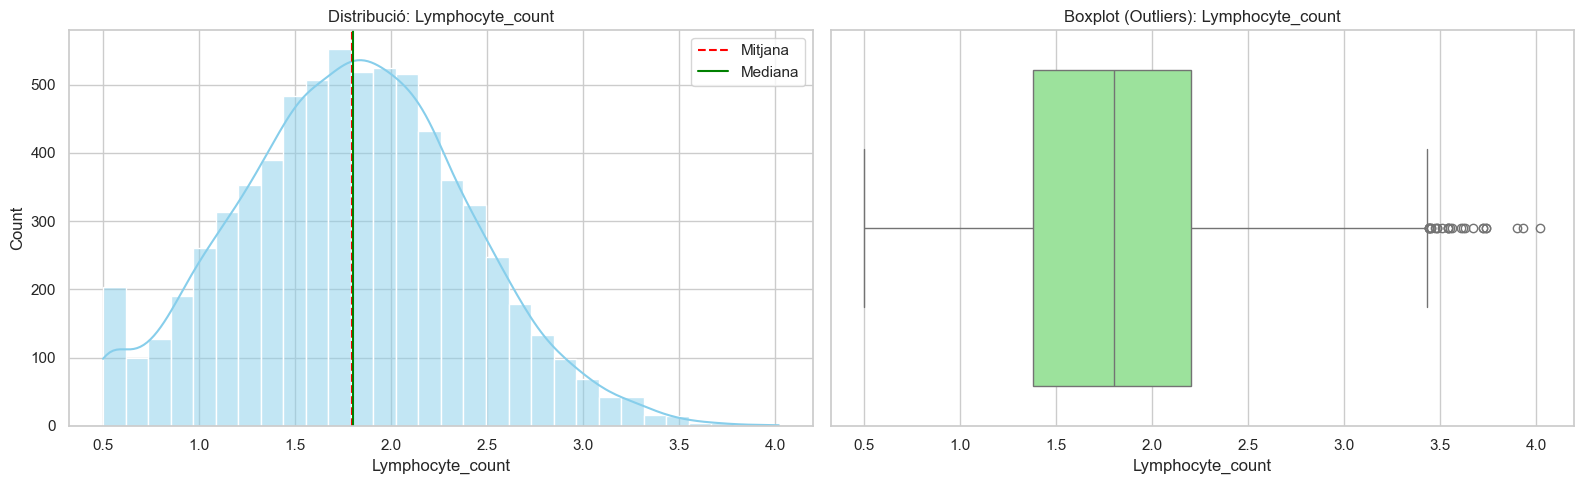

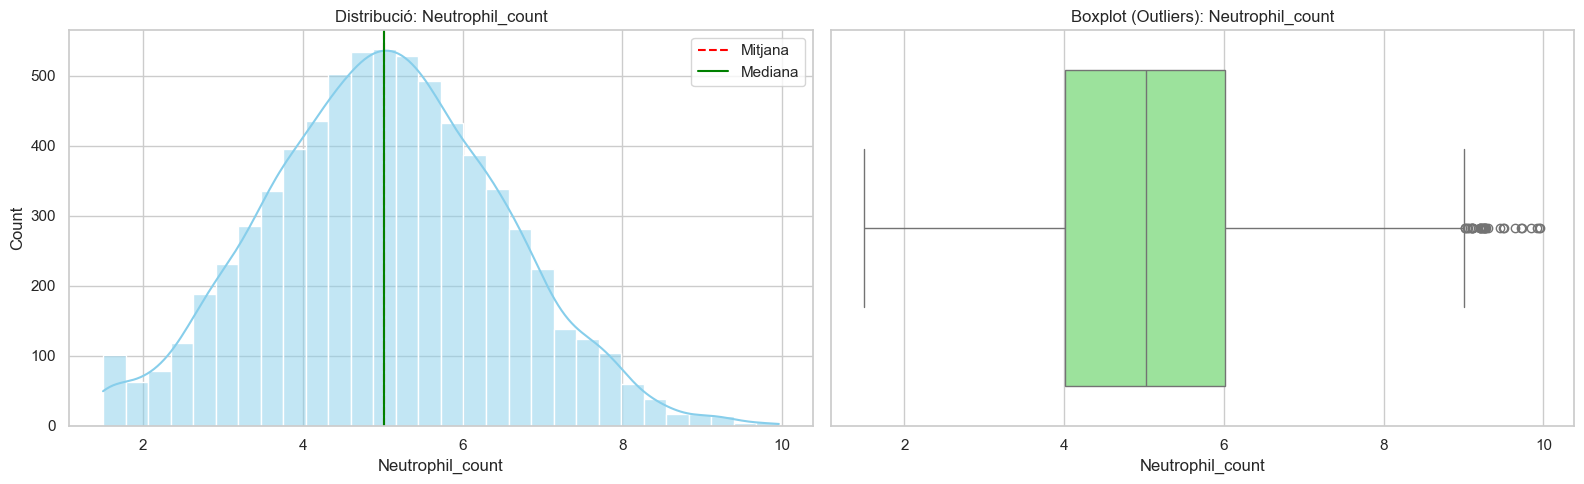

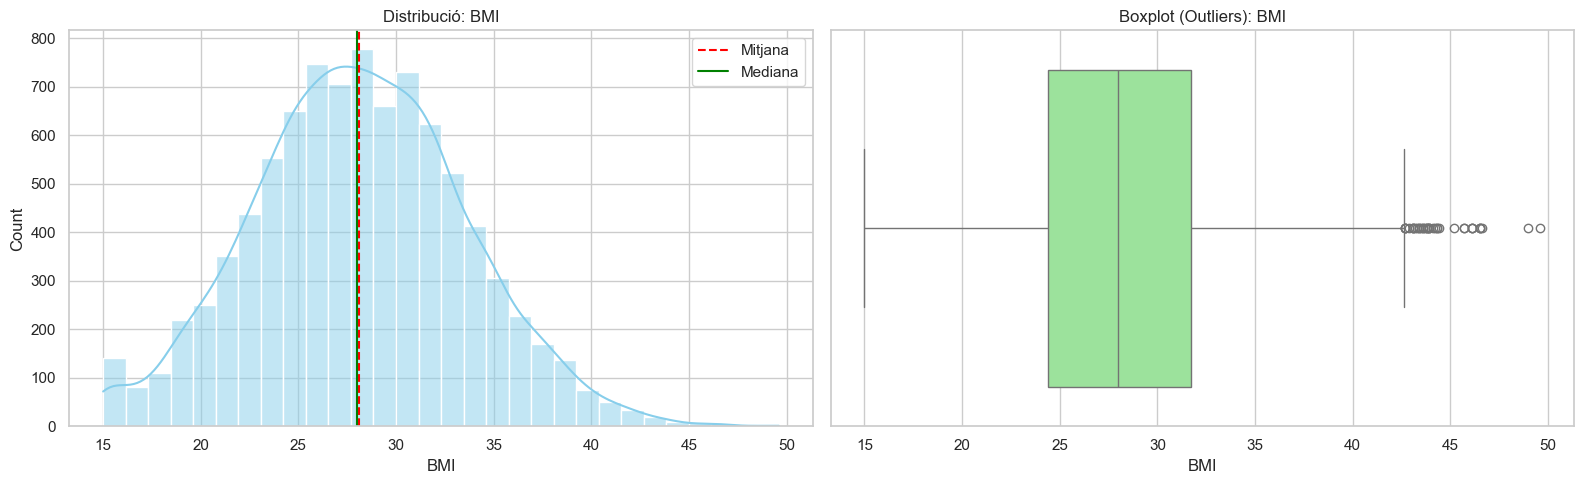

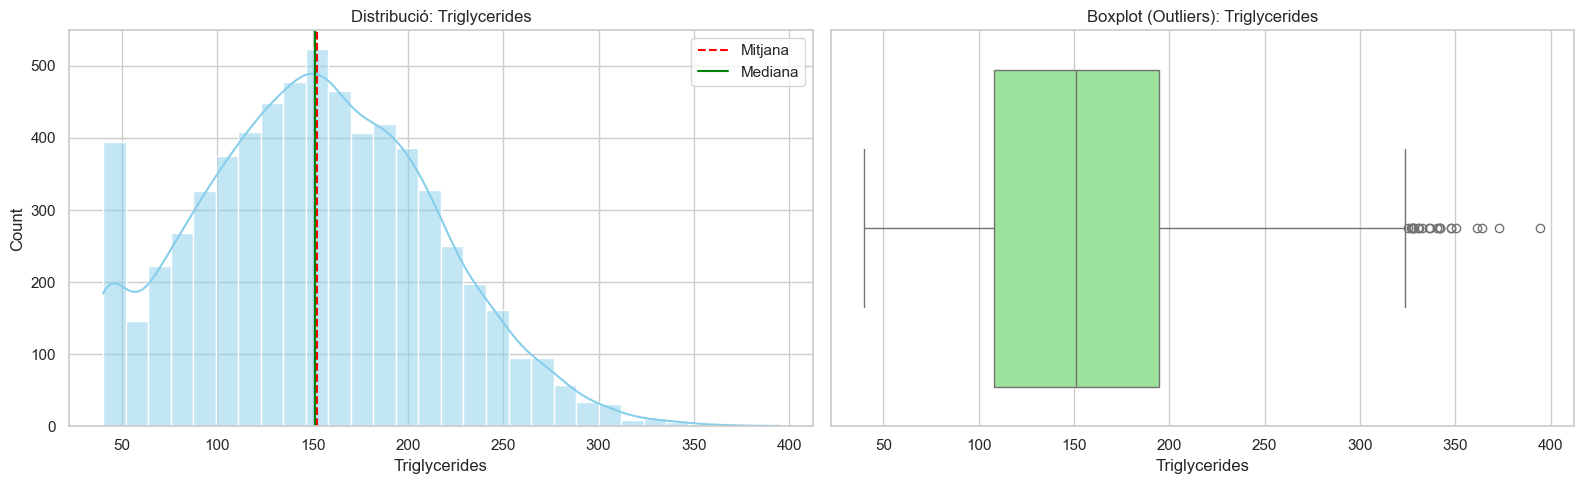

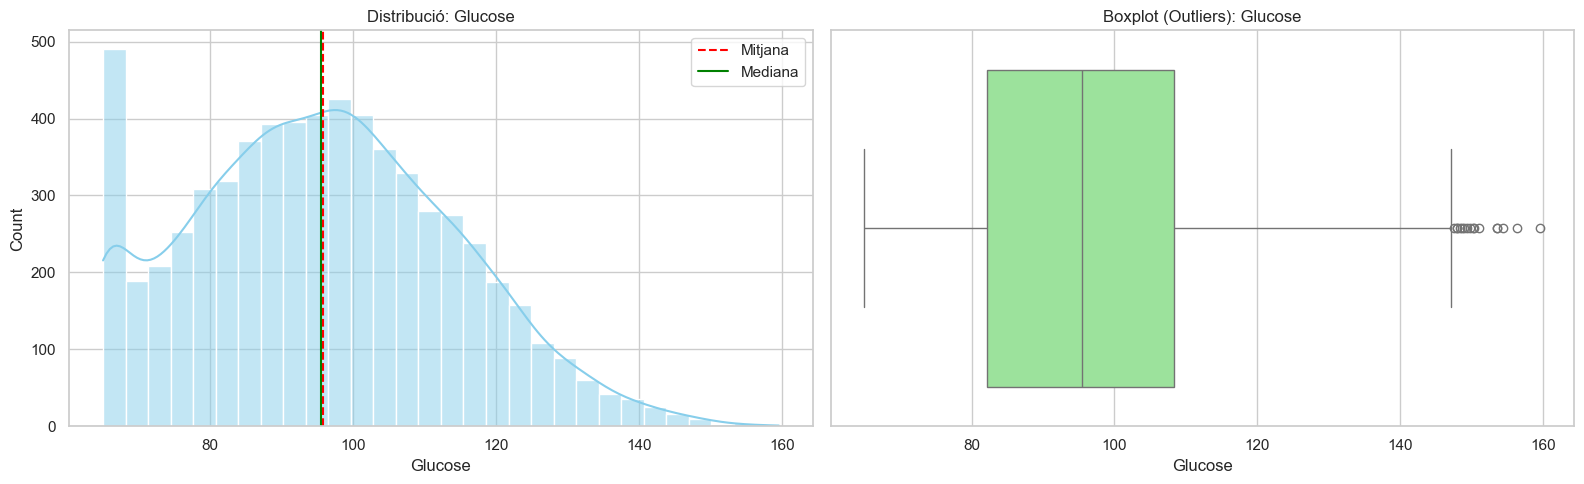

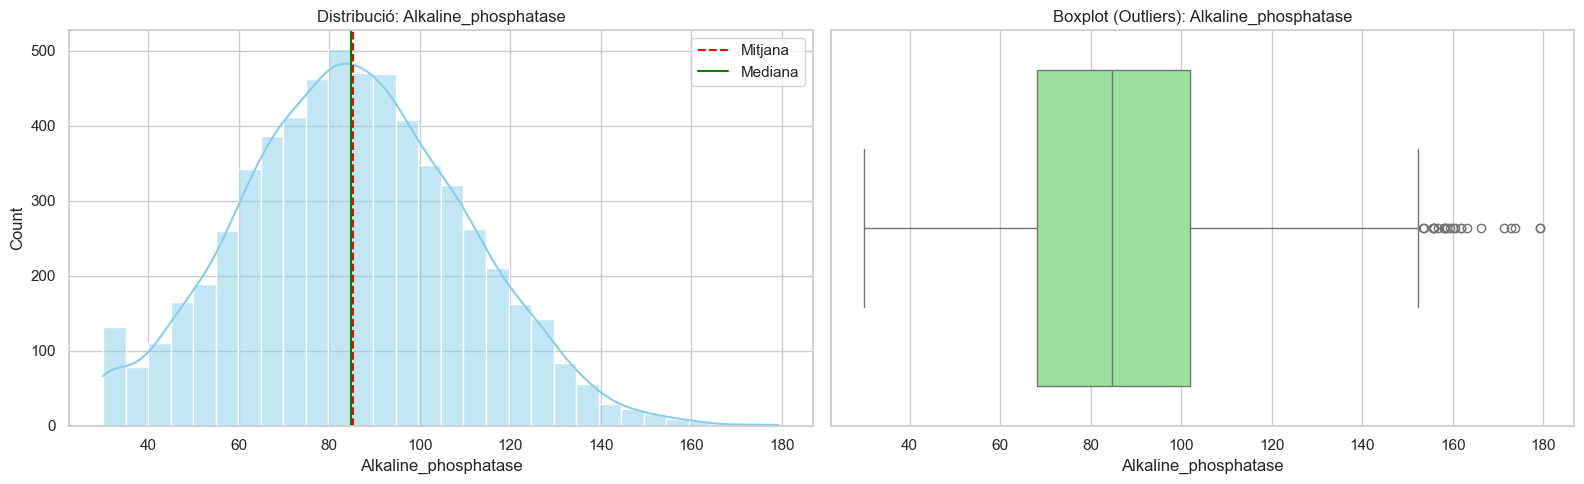

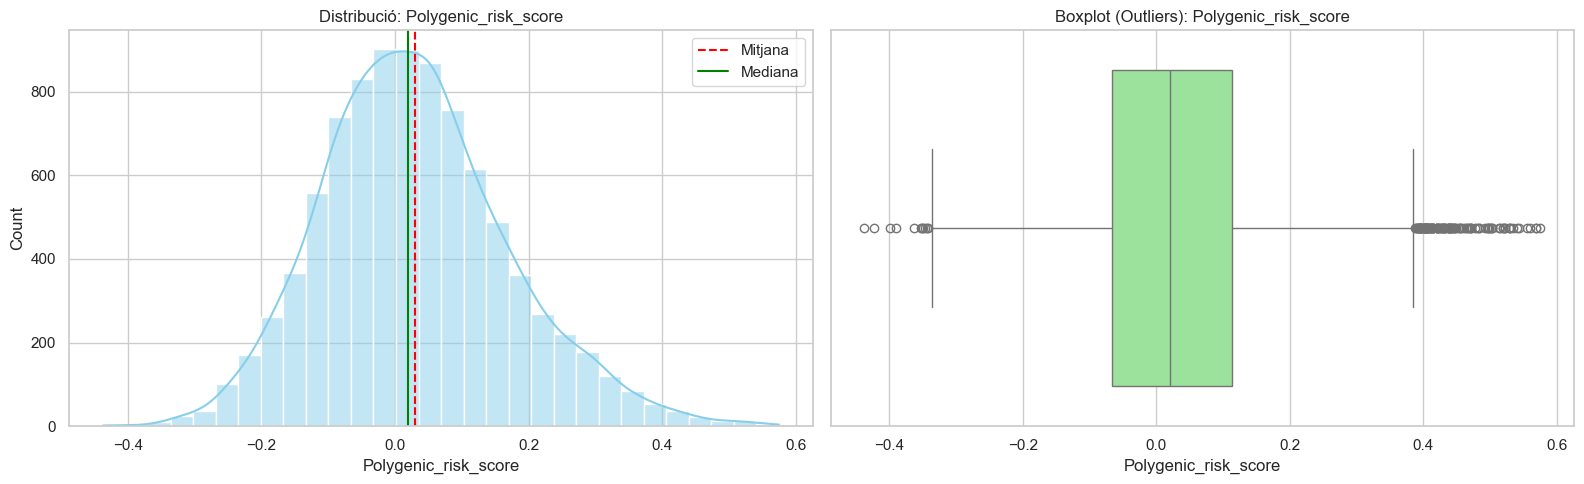

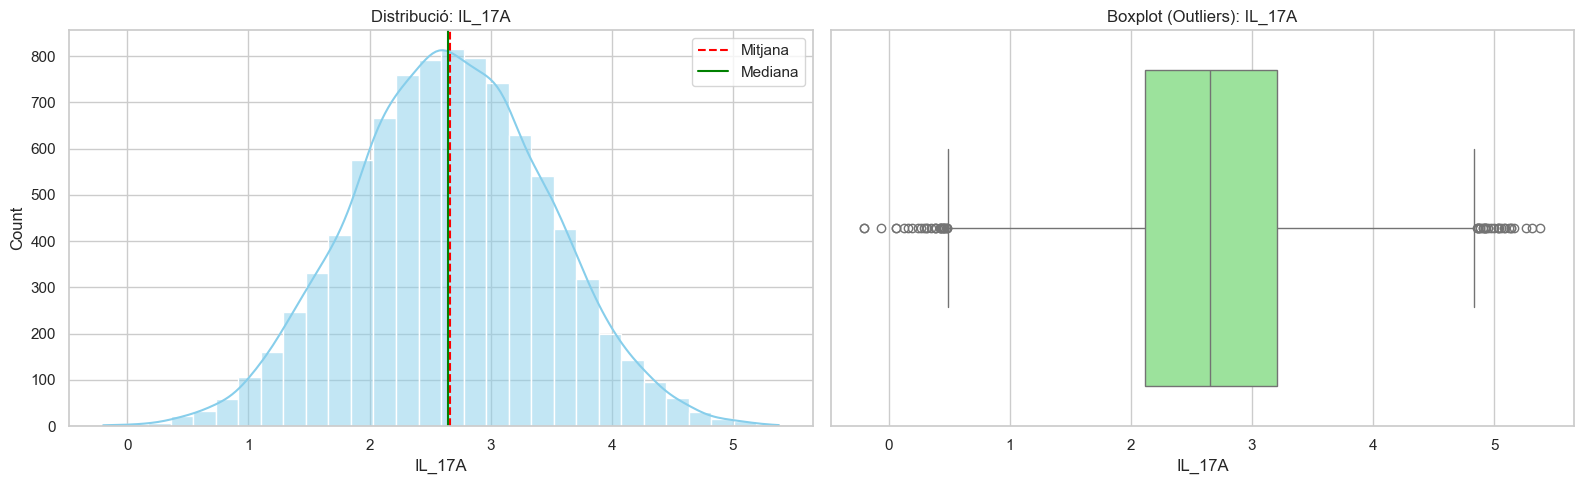

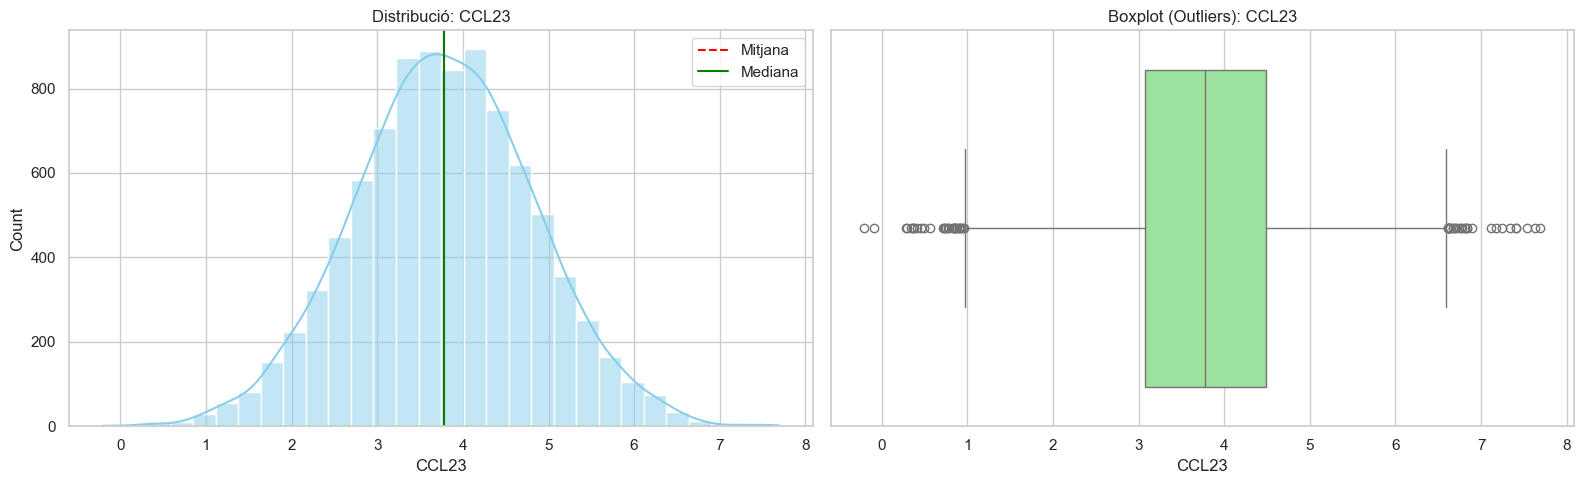

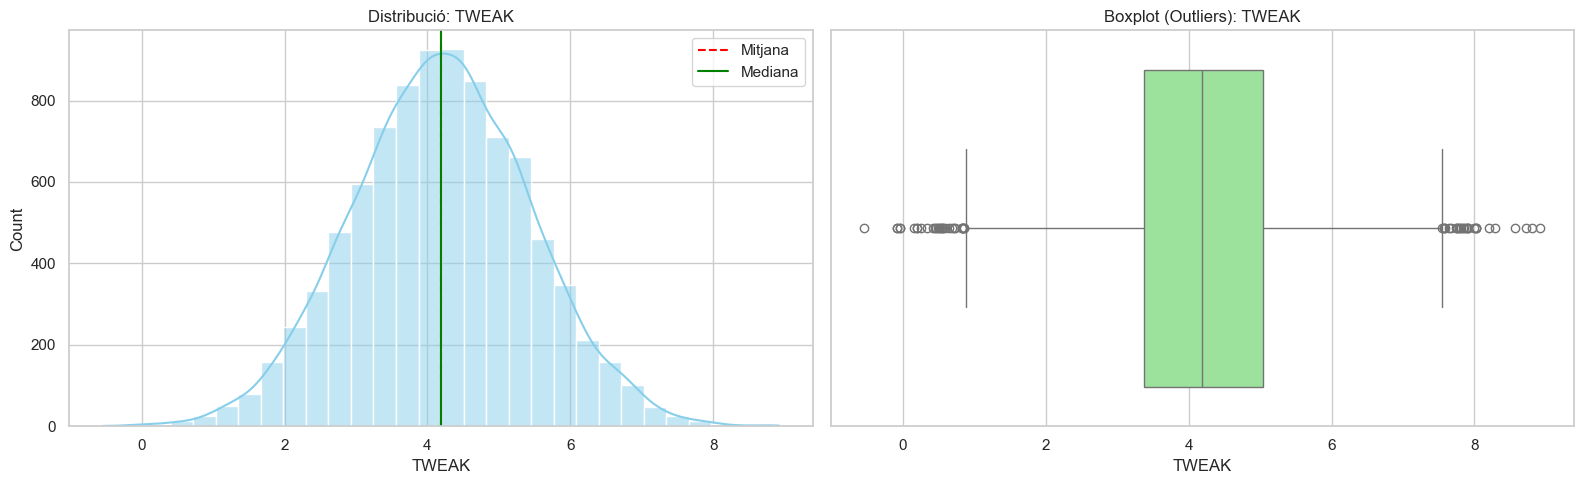

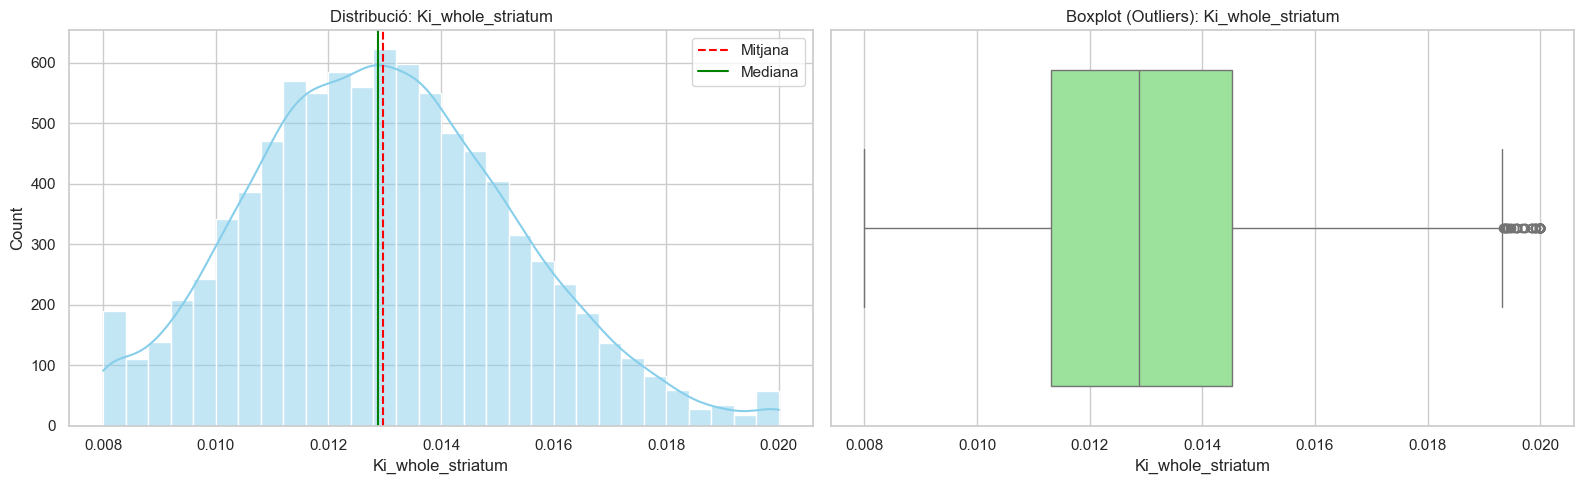

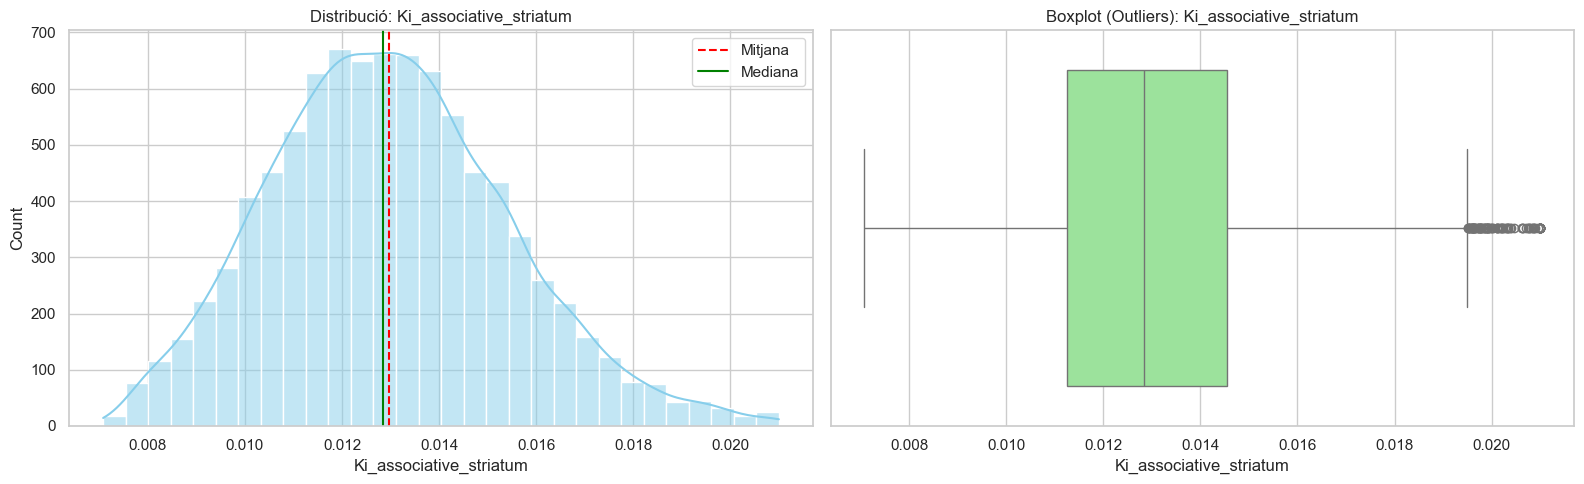

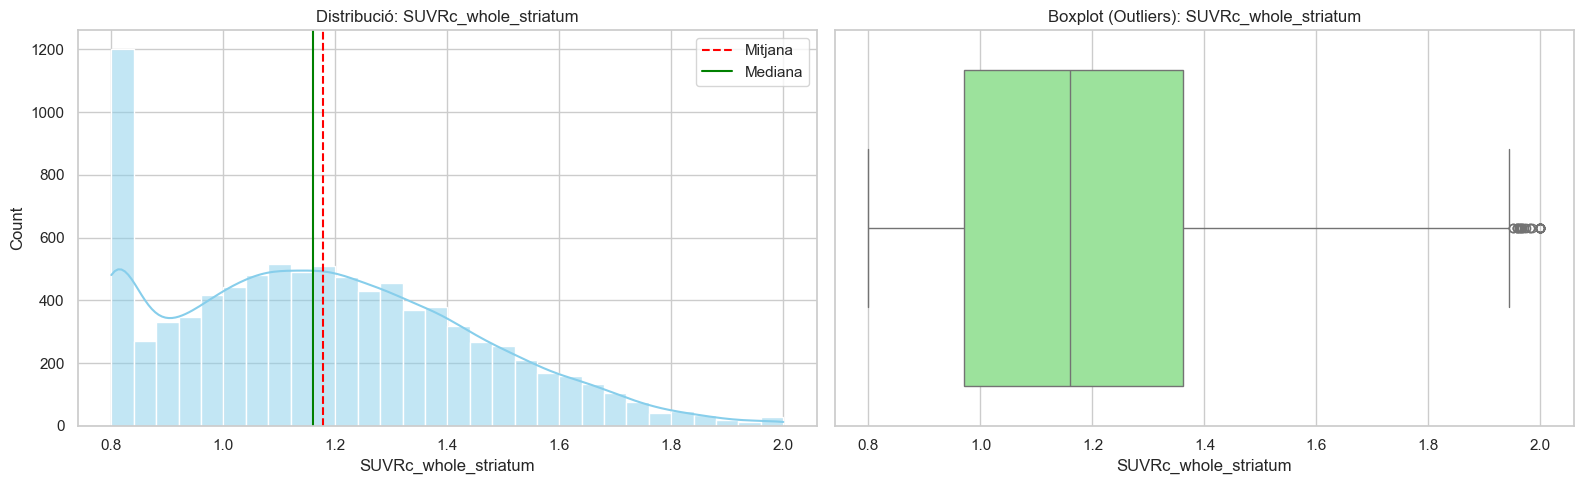

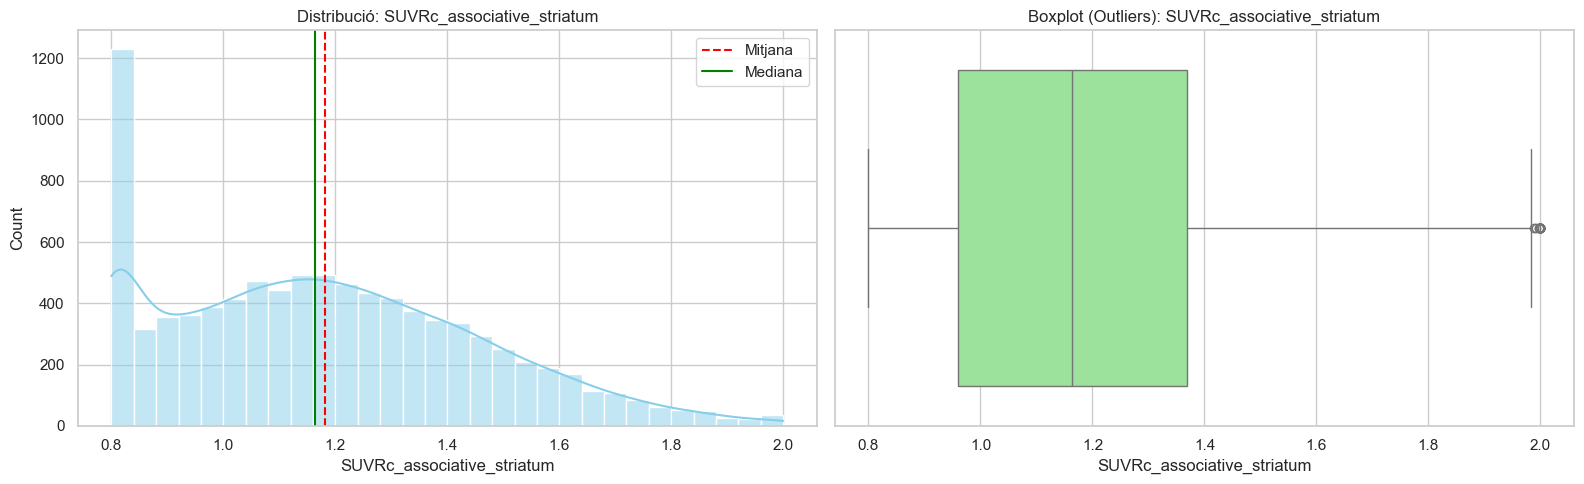

In [18]:
from scipy.stats import skew, kurtosis


num_cols = df.select_dtypes(include=['number']).columns
continuous_cols = [col for col in num_cols if df[col].nunique() > 10 and col != 'patient_id']

skew_data = []
for col in continuous_cols:
    # eliminem NaNs
    clean_series = df[col].dropna()
    col_skew = skew(clean_series)
    col_kurt = kurtosis(clean_series)
    
   # classfiquem l'asimetria
    if abs(col_skew) > 1:
        status = "🔴 MOLT ASIMÈTRICA (Requereix Log/BoxCox)"
    elif abs(col_skew) > 0.5:
        status = "🟠 MODERADA"
    else:
        status = "🟢 NORMAL (Simètrica)"
        
    skew_data.append({
        'Variable': col,
        'Skewness': col_skew,
        'Kurtosis': col_kurt,
        'Estat': status
    })

skew_df = pd.DataFrame(skew_data).sort_values('Skewness', key=abs, ascending=False)


print(skew_df.to_string(index=False))


sns.set_style("whitegrid")


#visualitzem les distribucions de les variables contínues
for col in continuous_cols:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # histograma amb KDE
    sns.histplot(data=df, x=col, kde=True, ax=axes[0], color='skyblue', bins=30)
    axes[0].set_title(f'Distribució: {col}')
    
    # mitjana i mediana
    axes[0].axvline(df[col].mean(), color='red', linestyle='--', label='Mitjana')
    axes[0].axvline(df[col].median(), color='green', linestyle='-', label='Mediana')
    axes[0].legend()

    # boxplot
    sns.boxplot(x=df[col], ax=axes[1], color='lightgreen')
    axes[1].set_title(f'Boxplot (Outliers): {col}')
    
    plt.tight_layout()
    plt.show()


Anàlisi de les correlacions de les variables numèriques per observar linearitat o colinearitat


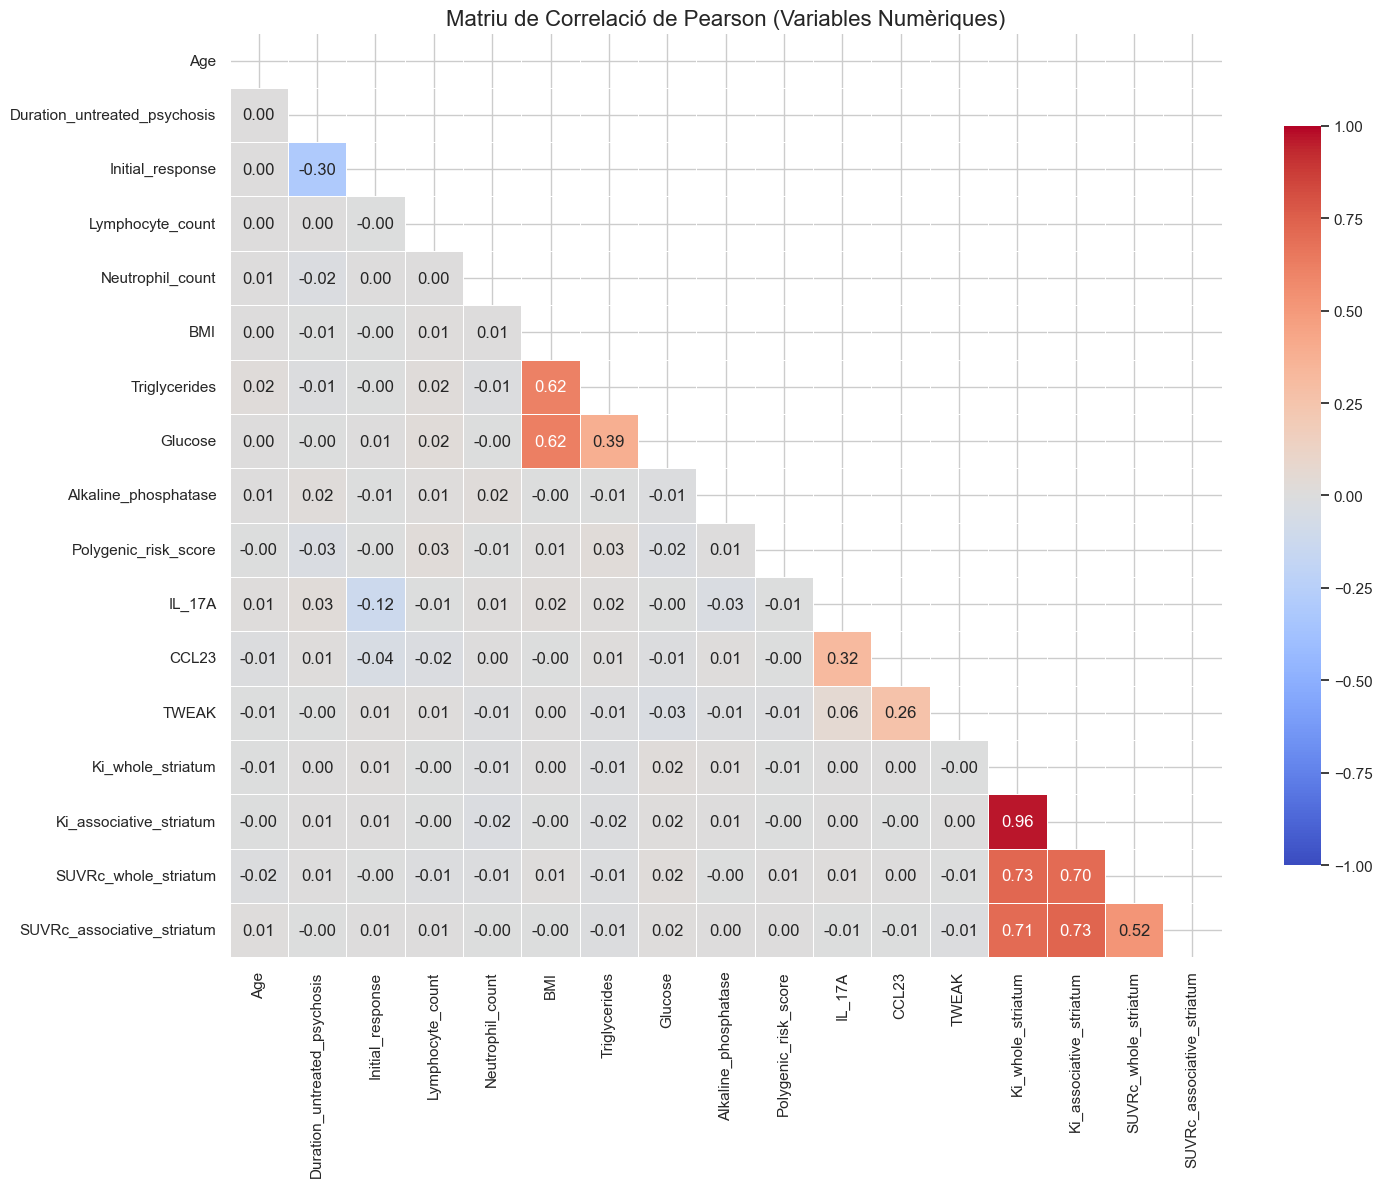

In [19]:

numerical_cols = df.select_dtypes(include=['number']).columns

# treiem les variables binàries i categòriques codificades numèricament
numerical_cols = [col for col in numerical_cols if df[col].nunique() > 10]
cols_to_analyze = [col for col in numerical_cols if col not in ['patient_id', 'TRS']]

# correlació de Pearson
corr_matrix = df[cols_to_analyze].corr()

# visualització (heatmap)
plt.figure(figsize=(16, 12))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# dibuixar el heatmap
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True,              # Mostrar números
            fmt=".2f",               # 2 decimals
            cmap='coolwarm',         # Blau-Vermell (Vermell = alta correlació positiva)
            vmax=1, vmin=-1,         # Escala de -1 a 1
            center=0,
            linewidths=.5,
            cbar_kws={"shrink": .8})

plt.title('Matriu de Correlació de Pearson (Variables Numèriques)', fontsize=16)
plt.show()

Anàlisi de valors extrems (outliers)

In [20]:
num_cols = [
    c for c in df.select_dtypes(include='number').columns
    if df[c].nunique() > 10 and c not in ['patient_id']
]

outlier_summary = []

#fem la detecció d'outliers per IQR
for col in num_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask = (df[col] < lower) | (df[col] > upper)
    outlier_summary.append({
        'variable': col,
        'n_outliers': int(mask.sum()),
        'pct_outliers': mask.mean() * 100
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('pct_outliers', ascending=False)
display(outlier_df)

,variable,n_outliers,pct_outliers
1,Duration_untreated_psychosis,651,7.233333
0,Age,360,4.000000
9,Polygenic_risk_score,125,1.388889
14,Ki_associative_striatum,83,0.922222
13,Ki_whole_striatum,71,0.788889
11,CCL23,59,0.655556
12,TWEAK,58,0.644444
10,IL_17A,57,0.633333
5,BMI,39,0.433333
15,SUVRc_whole_striatum,35,0.388889


Anàlisi de les components principals. Fem una imputació perquè PCA no tolera NaNs. També escalem les dades perquè PCA és sensible a l'escala de les variables.

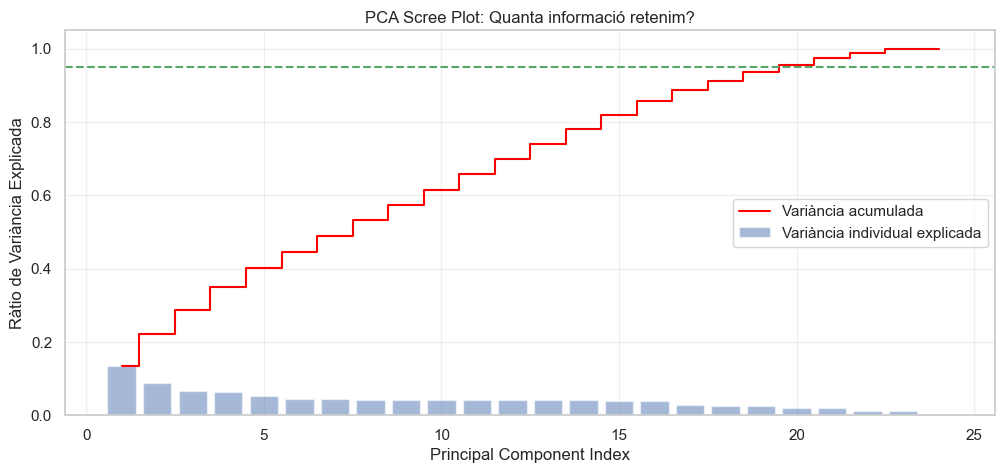

In [21]:
features = df.select_dtypes(include=['number']).columns.tolist()
if 'patient_id' in features: features.remove('patient_id')
if 'TRS' in features: features.remove('TRS')

X = df[features]

# imputem
imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)

# pca necessita dades escalades
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# scree plot
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(12, 5))

# variància individual
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center',
        label='Variància individual explicada')

# variància acumulada
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid',
         label='Variància acumulada', color='red')

plt.ylabel('Ràtio de Variància Explicada')
plt.xlabel('Principal Component Index')
plt.title('PCA Scree Plot: Quanta informació retenim?')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# linia de tall al 95%
plt.axhline(y=0.95, color='g', linestyle='--', label='95% threshold')
plt.show()

## 2. Preprocessament de dades per model

### 2.1 Per a SVM

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# carregar dades
df = pd.read_csv('trs_train.csv')

# s X i y
if 'TRS' in df.columns:
    X = df.drop('TRS', axis=1)
    y = df['TRS']
else:
    raise ValueError("No s'ha trobat la columna objectiu 'TRS'")

# eliminar patient_id
if 'patient_id' in X.columns:
    X = X.drop('patient_id', axis=1)


1. Particionar

In [3]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


2. Codificació de variables categòriques amb One-Hot Encoding

In [4]:
cat_cols = X_train_svm.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train_svm.select_dtypes(exclude=['object']).columns.tolist()

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

ohe.fit(X_train_svm[cat_cols])

X_train_cat_encoded = ohe.transform(X_train_svm[cat_cols])
X_test_cat_encoded = ohe.transform(X_test_svm[cat_cols])

# fem un dataframe amb les noves columnes
new_cat_names = ohe.get_feature_names_out(cat_cols)
X_train_cat_df = pd.DataFrame(X_train_cat_encoded, columns=new_cat_names, index=X_train_svm.index)
X_test_cat_df = pd.DataFrame(X_test_cat_encoded, columns=new_cat_names, index=X_test_svm.index)

# recombinem de nou
X_train_svm = pd.concat([X_train_svm[num_cols], X_train_cat_df], axis=1)
X_test_svm = pd.concat([X_test_svm[num_cols], X_test_cat_df], axis=1)


3. Imputació de valors faltants amb KNNImputer amb ``k=5``

In [5]:
# escalat temporal
scaler_temp = StandardScaler()
X_train_scaled_temp = scaler_temp.fit_transform(X_train_svm)
X_test_scaled_temp = scaler_temp.transform(X_test_svm)

# apliquem knn
knn = KNNImputer(n_neighbors=5)
X_train_imputed_vals = knn.fit_transform(X_train_scaled_temp)
X_test_imputed_vals = knn.transform(X_test_scaled_temp)

# tornem a l'escala original 
X_train_svm = pd.DataFrame(scaler_temp.inverse_transform(X_train_imputed_vals), 
                           columns=X_train_svm.columns, index=X_train_svm.index)
X_test_svm = pd.DataFrame(scaler_temp.inverse_transform(X_test_imputed_vals), 
                          columns=X_test_svm.columns, index=X_test_svm.index)


4. Transformació de variables numèriques per reduir skewness amb PowerTransformer (Box-Cox o Yeo-Johnson segons correspongui)

In [6]:
pt = PowerTransformer(method='yeo-johnson', standardize=False)

cols_skewed = ['Duration_untreated_psychosis', 'Age']

pt.fit(X_train_svm[cols_skewed]) #ho fewm només en train

X_train_svm[cols_skewed] = pt.transform(X_train_svm[cols_skewed])
X_test_svm[cols_skewed] = pt.transform(X_test_svm[cols_skewed])

5. Escalat de les variables numèriques amb StandardScaler

In [7]:
scaler_final = StandardScaler()

X_train_svm_final = scaler_final.fit_transform(X_train_svm)
X_test_svm_final = scaler_final.transform(X_test_svm)

6. Entrenament del model SVM

In [ ]:
#calculem proporció de la classe objectiu per definir pesos
class_counts = y_train_svm.value_counts()
print("Comptatge de classes en el conjunt d'entrenament:") 
print(class_counts)
print("\n" + "="*50 + "\n")

class_weights = {
    0: 1,
    1: class_counts[0] / class_counts[1]  # Pes inversament proporcional a la freqüència
}

param_grid = {
    'C': [0.001, 0.01, 0.1, 1], 
    'gamma': ['scale', 'auto', 0.01],
    'kernel': ['rbf', 'linear', 'poly'],
    'class_weight': ['balanced', {0: 1, 1: 2}, class_weights],
    'degree': [2, 3, 4]  
}
svm_base = SVC(class_weight='balanced', random_state=42)


grid_search = GridSearchCV(
    estimator=svm_base,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1
)

# executar grid query
print("Iniciant Grid Search per SVM...")
grid_search.fit(X_train_svm_final, y_train_svm)

# mostrem resultats
print("\n" + "="*50)
print(f"MILLORS PARÀMETRES: {grid_search.best_params_}")
print(f"MILLOR F1-SCORE (CV): {grid_search.best_score_:.4f}")
print("="*50 + "\n")

# avaluem el millor model en el test set
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_svm_final)

print("--- RESULTATS DEL MILLOR MODEL (TEST SET) ---")
print(classification_report(y_test_svm, y_pred_best))

# retornem el valor f1-score del millor model en el test set
f1 = f1_score(y_test_svm, y_pred_best, average='macro')
print(f"F1-Score del millor model en Test Set: {f1:.4f}")



Comptatge de classes en el conjunt d'entrenament:
TRS
0    4930
1    2270
Name: count, dtype: int64


Iniciant Grid Search per SVM...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

MILLORS PARÀMETRES: {'C': 0.1, 'class_weight': 'balanced', 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
MILLOR F1-SCORE (CV): 0.5895

--- RESULTATS DEL MILLOR MODEL (TEST SET) ---
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      1232
           1       0.40      0.53      0.46       568

    accuracy                           0.60      1800
   macro avg       0.57      0.58      0.57      1800
weighted avg       0.64      0.60      0.62      1800

F1-Score del millor model en Test Set: 0.5729


Ajustem el millor model.

In [9]:
best_svm = SVC(
    C = 0.1,
    class_weight = 'balanced',
    degree = 3,
    gamma = 'auto',
    kernel='poly'
)

best_svm.fit(X_train_svm_final, y_train_svm)

,C,0.1
,kernel,'poly'
,degree,3
,gamma,'auto'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


Generem la matriu de confusió

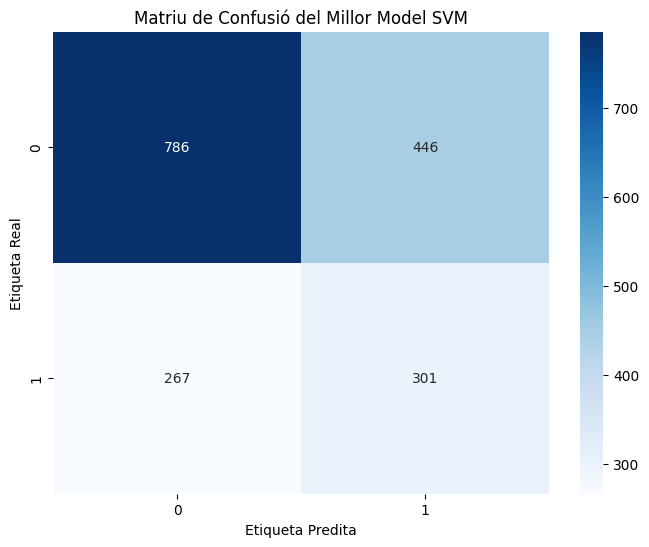

In [10]:
y_pred_best = best_svm.predict(X_test_svm_final)

cm = confusion_matrix(y_test_svm, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_svm.classes_, 
            yticklabels=best_svm.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió del Millor Model SVM')
plt.show()

Generem corba ROC i AUC per avaluar el model.

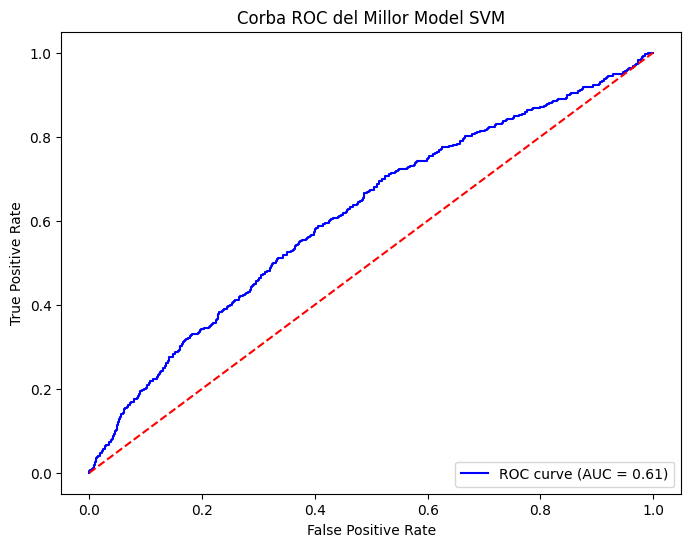

In [11]:
y_prob_best = best_svm.decision_function(X_test_svm_final)
fpr, tpr, thresholds = roc_curve(y_test_svm, y_prob_best)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Corba ROC del Millor Model SVM')
plt.legend(loc='lower right')
plt.show()

Mirem corbes d'entrenament i validació per detectar overfitting o underfitting.

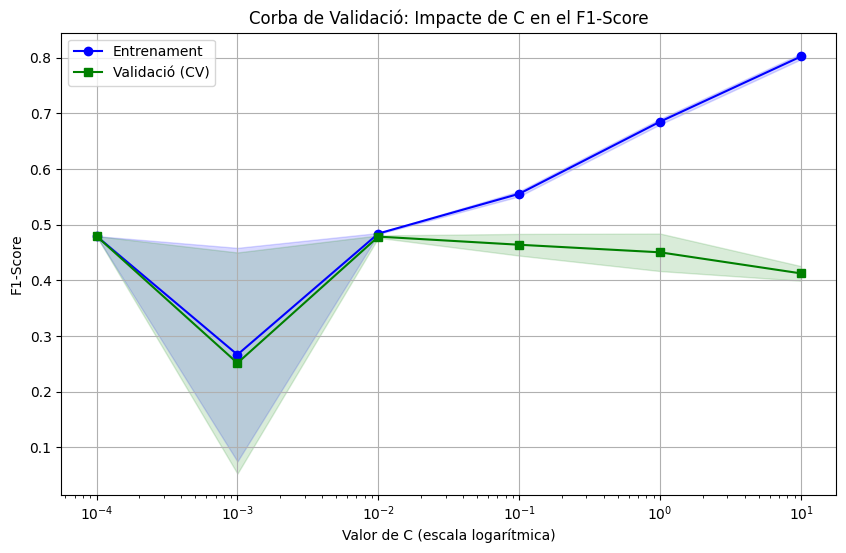

In [22]:
param_range = np.logspace(-4, 1, 6) # C des de 0.0001 fins 10, log scale

train_scores, test_scores = validation_curve(
    best_svm, X_train_svm_final, y_train_svm, 
    param_name="C", 
    param_range=param_range,
    cv=5, 
    scoring="f1", 
    n_jobs=-1
)

# processar resultats
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Entrenament", color="blue", marker="o")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")
plt.plot(param_range, test_mean, label="Validació (CV)", color="green", marker="s")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="green")

plt.title("Corba de Validació: Impacte de C en el F1-Score")
plt.xlabel("Valor de C (escala logarítmica)")
plt.ylabel("F1-Score")
plt.xscale('log')
plt.legend(loc="best")
plt.grid(True)
plt.show()

Mirem amb més detall el tram entre 0.01 i 0.1 de C per trobar el millor punt d'equilibri entre overfitting i underfitting.

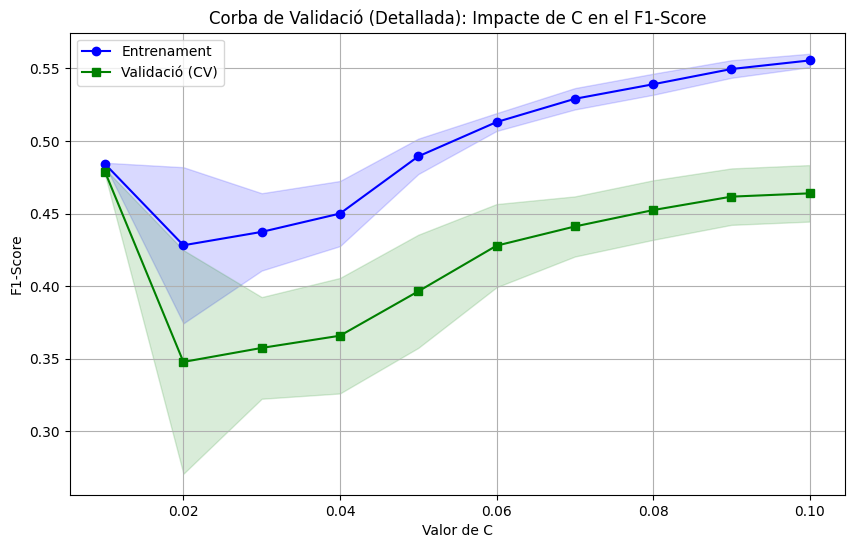

In [ ]:
param_range_fine = np.linspace(0.01, 0.1, 10)
train_scores_fine, test_scores_fine = validation_curve(
    best_svm, X_train_svm_final, y_train_svm, 
    param_name="C", 
    param_range=param_range_fine,
    cv=5, 
    scoring="f1", 
    n_jobs=-1
)
# processar resultats
train_mean_fine = np.mean(train_scores_fine, axis=1)
train_std_fine = np.std(train_scores_fine, axis=1)
test_mean_fine = np.mean(test_scores_fine, axis=1)
test_std_fine = np.std(test_scores_fine, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(param_range_fine, train_mean_fine, label="Entrenament", color="blue", marker="o")
plt.fill_between(param_range_fine, train_mean_fine - train_std_fine, train_mean_fine + train_std_fine, alpha=0.15, color="blue")
plt.plot(param_range_fine, test_mean_fine, label="Validació (CV)", color="green", marker="s")
plt.fill_between(param_range_fine, test_mean_fine - test_std_fine, test_mean_fine + test_std_fine, alpha=0.15, color="green")
plt.title("Corba de Validació (Detallada): Impacte de C en el F1-Score")
plt.xlabel("Valor de C")
plt.ylabel("F1-Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()


Generem el model final amb el millor valor de `C` i obtenim les següents mètriques al test set:

              precision    recall  f1-score   support

           0       0.72      0.06      0.10      1232
           1       0.32      0.95      0.48       568

    accuracy                           0.34      1800
   macro avg       0.52      0.50      0.29      1800
weighted avg       0.60      0.34      0.22      1800



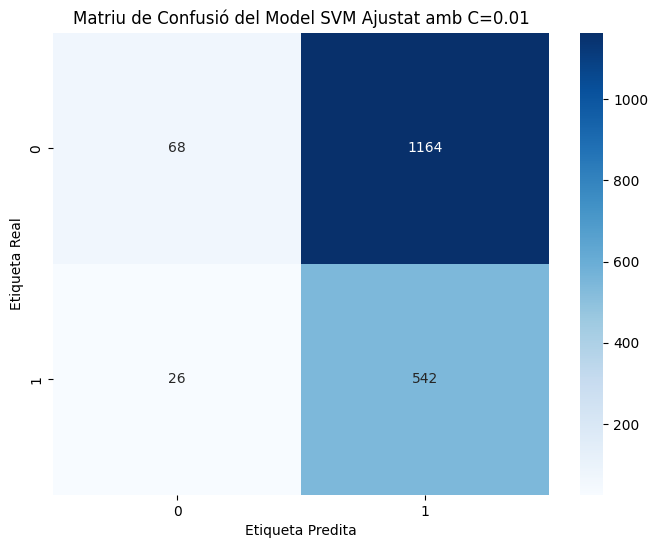

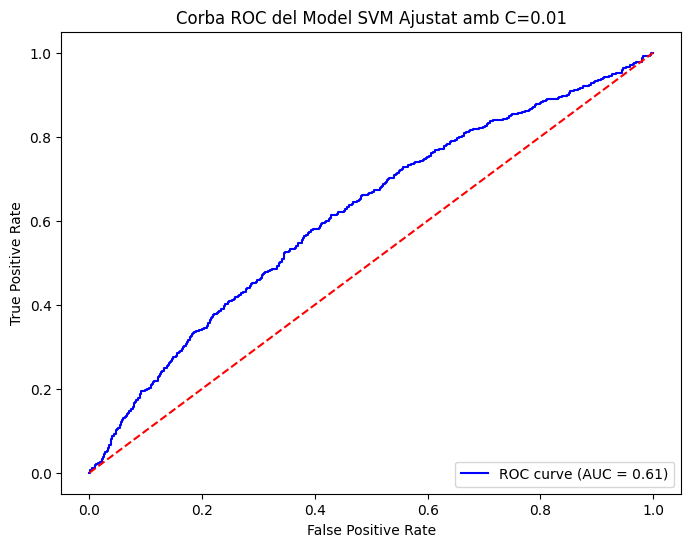

In [29]:
best_svm = SVC(C=0.01, gamma='auto', kernel='poly', degree=3, class_weight='balanced', random_state=42)
best_svm.fit(X_train_svm_final, y_train_svm)
y_pred_best = best_svm.predict(X_test_svm_final)

print(classification_report(y_test_svm, y_pred_best))

cm = confusion_matrix(y_test_svm, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_svm.classes_, 
            yticklabels=best_svm.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió del Model SVM Ajustat amb C=0.01')
plt.show()

# Corba ROC i AUC
from sklearn.metrics import roc_curve, auc
y_prob_best = best_svm.decision_function(X_test_svm_final)
fpr, tpr, thresholds = roc_curve(y_test_svm, y_prob_best)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Corba ROC del Model SVM Ajustat amb C=0.01')
plt.legend(loc='lower right')
plt.show()

Provem un nou model amb kernel RBF.

In [30]:
best_svm = SVC(kernel='rbf', class_weight='balanced', random_state=42)

grid_search_rbf = GridSearchCV(
    estimator=best_svm,
    param_grid={
        'C': [0.001, 0.01, 0.1, 1],
        'gamma': ['scale', 'auto', 0.01, 0.1]
    },
    cv=5,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1
)

# executar grid query
grid_search_rbf.fit(X_train_svm_final, y_train_svm)
# mostrem resultats
print("\n" + "="*50)
print(f"MILLORS PARÀMETRES (RBF): {grid_search_rbf.best_params_}")
print(f"MILLOR F1-SCORE (CV) (RBF): {grid_search_rbf.best_score_:.4f}")
print("="*50 + "\n")


Fitting 5 folds for each of 16 candidates, totalling 80 fits

MILLORS PARÀMETRES (RBF): {'C': 1, 'gamma': 'auto'}
MILLOR F1-SCORE (CV) (RBF): 0.5775



Avaluem sobre el test set.

--- RESULTATS DEL MILLOR MODEL RBF (TEST SET) ---
              precision    recall  f1-score   support

           0       0.75      0.58      0.65      1232
           1       0.39      0.58      0.47       568

    accuracy                           0.58      1800
   macro avg       0.57      0.58      0.56      1800
weighted avg       0.64      0.58      0.60      1800



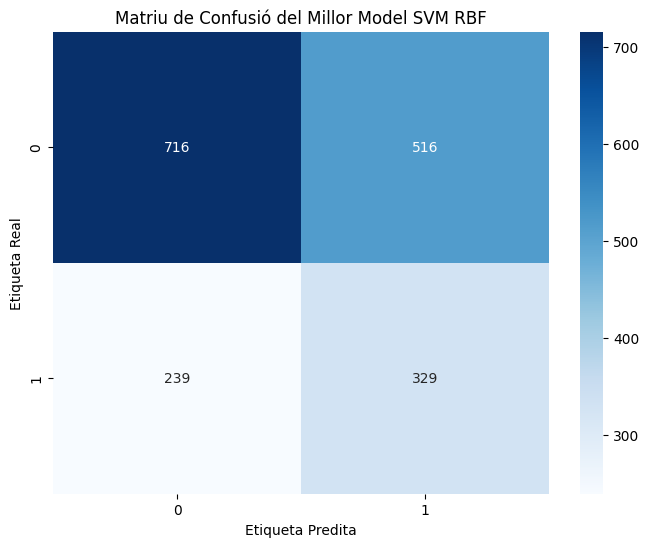

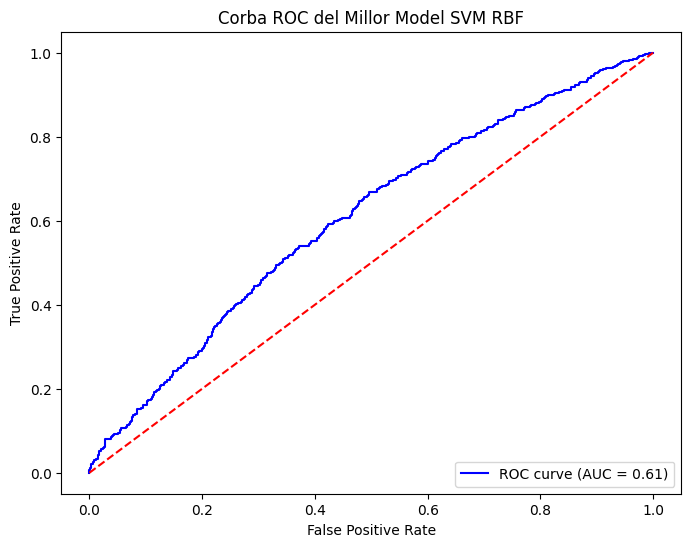

In [ ]:
best_svm = SVC( C=1, gamma='auto', kernel='rbf', class_weight='balanced', random_state=42)
best_svm.fit(X_train_svm_final, y_train_svm)
y_pred_best = best_svm.predict(X_test_svm_final)
print("--- RESULTATS DEL MILLOR MODEL RBF (TEST SET) ---")
print(classification_report(y_test_svm, y_pred_best))
cm = confusion_matrix(y_test_svm, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_svm.classes_,
            yticklabels=best_svm.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió del Millor Model SVM RBF')
plt.show()

#corba ROC i AUC
y_prob_best = best_svm.decision_function(X_test_svm_final)
fpr, tpr, thresholds = roc_curve(y_test_svm, y_prob_best)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Corba ROC del Millor Model SVM RBF')
plt.legend(loc='lower right')
plt.show()

Comprovem si hi ha overfitting o underfitting amb les corbes de validació en funció de C.

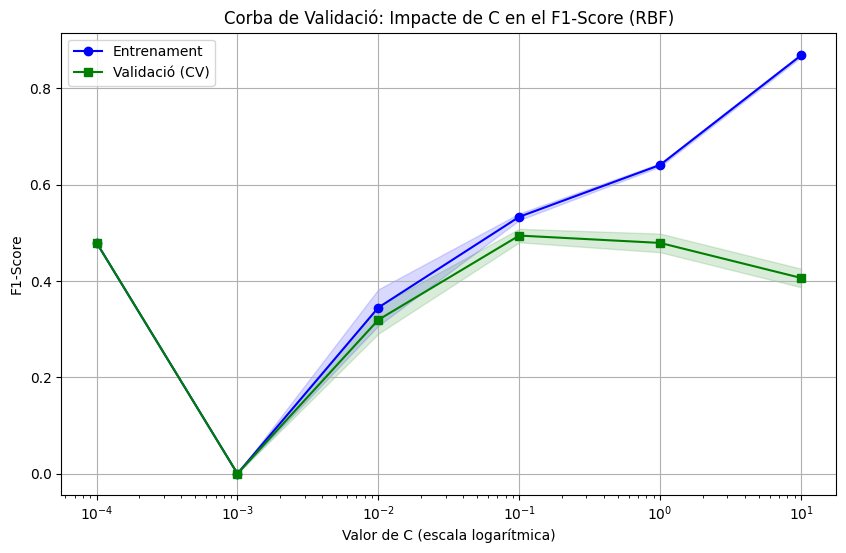

In [ ]:
param_range = np.logspace(-4, 1, 6) # C des de 0.0001 fins 10, log scale
train_scores, test_scores = validation_curve(
    best_svm, X_train_svm_final, y_train_svm, 
    param_name="C", 
    param_range=param_range,
    cv=5, 
    scoring="f1", 
    n_jobs=-1
)
# processar resultats
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Entrenament", color="blue", marker="o")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")
plt.plot(param_range, test_mean, label="Validació (CV)", color="green", marker="s")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="green")
plt.title("Corba de Validació: Impacte de C en el F1-Score (RBF)")
plt.xlabel("Valor de C (escala logarítmica)")
plt.ylabel("F1-Score")
plt.xscale('log')
plt.legend(loc="best")
plt.grid(True)
plt.show()

Mirem amb més detall els valors entre 0.1 i 1 de C per trobar el millor punt d'equilibri entre overfitting i underfitting.

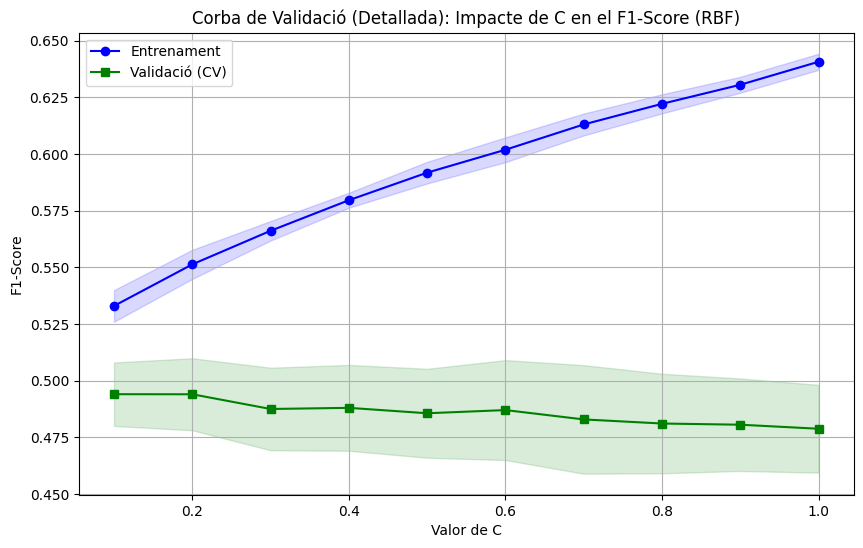

In [ ]:
param_range_fine = np.linspace(0.1, 1, 10)
train_scores_fine, test_scores_fine = validation_curve(
    best_svm, X_train_svm_final, y_train_svm, 
    param_name="C", 
    param_range=param_range_fine,
    cv=5, 
    scoring="f1", 
    n_jobs=-1
)
# processar resultats
train_mean_fine = np.mean(train_scores_fine, axis=1)
train_std_fine = np.std(train_scores_fine, axis=1)
test_mean_fine = np.mean(test_scores_fine, axis=1)
test_std_fine = np.std(test_scores_fine, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(param_range_fine, train_mean_fine, label="Entrenament", color="blue", marker="o")
plt.fill_between(param_range_fine, train_mean_fine - train_std_fine, train_mean_fine + train_std_fine, alpha=0.15, color="blue")
plt.plot(param_range_fine, test_mean_fine, label="Validació (CV)", color="green", marker="s")
plt.fill_between(param_range_fine, test_mean_fine - test_std_fine, test_mean_fine + test_std_fine, alpha=0.15, color="green")
plt.title("Corba de Validació (Detallada): Impacte de C en el F1-Score (RBF)")
plt.xlabel("Valor de C")
plt.ylabel("F1-Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

Ens quedem amb C=0.1. Visualitzem la matriu de confusió i la corba ROC.

              precision    recall  f1-score   support

           0       0.76      0.53      0.63      1232
           1       0.38      0.63      0.48       568

    accuracy                           0.56      1800
   macro avg       0.57      0.58      0.55      1800
weighted avg       0.64      0.56      0.58      1800



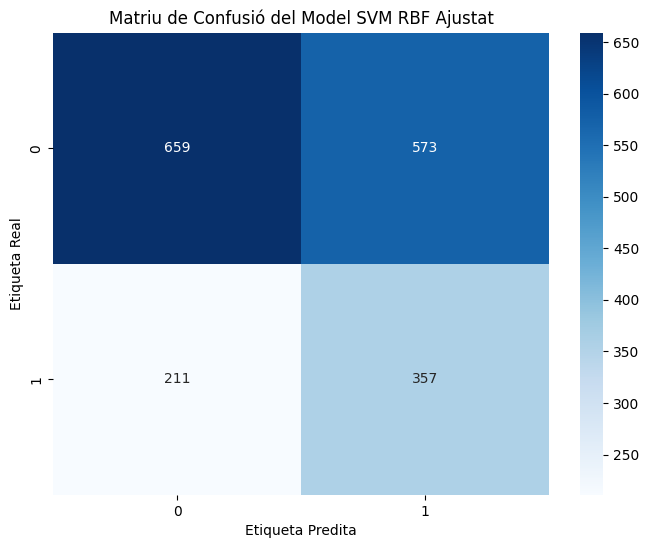

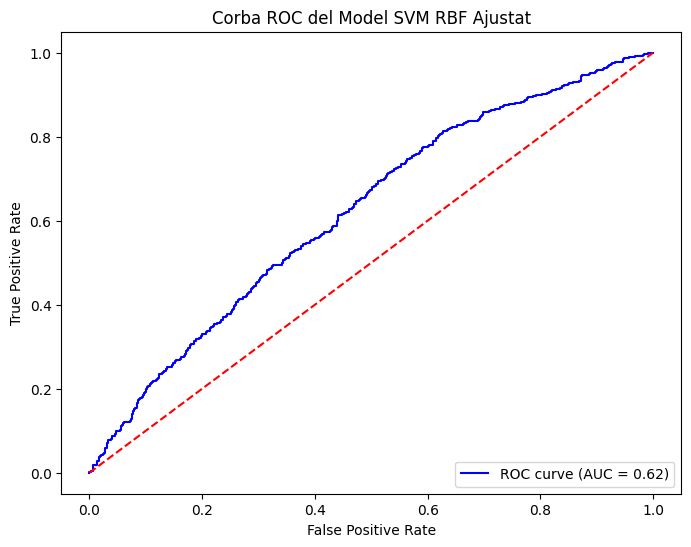

In [ ]:
best_svm_rbf = SVC(C=0.1, gamma='auto', kernel='rbf', class_weight='balanced', random_state=42)
best_svm_rbf.fit(X_train_svm_final, y_train_svm)
y_pred_best = best_svm_rbf.predict(X_test_svm_final)
print(classification_report(y_test_svm, y_pred_best))

cm = confusion_matrix(y_test_svm, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_svm_rbf.classes_, 
            yticklabels=best_svm_rbf.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió del Model SVM RBF Ajustat')
plt.show()
# Corba ROC i AUC
y_prob_best = best_svm_rbf.decision_function(X_test_svm_final)
fpr, tpr, thresholds = roc_curve(y_test_svm, y_prob_best)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Corba ROC del Model SVM RBF Ajustat')
plt.legend(loc='lower right')
plt.show()

Fem una submission al concurs amb el model final.

In [40]:
# fem tot el preprocessament fet per SVM al trs_eval.csv i guardem els resultats en un nou fitxer
df_eval = pd.read_csv('trs_eval.csv')
patient_ids = df_eval['patient_id']
X_eval = df_eval.drop('patient_id', axis=1)
# codifiquem les variables categòriques
X_eval_cat_encoded = ohe.transform(X_eval[cat_cols])
X_eval_cat_df = pd.DataFrame(X_eval_cat_encoded, columns=new_cat_names, index=X_eval.index)
X_eval = pd.concat([X_eval[num_cols], X_eval_cat_df], axis=1)
# escalat temporal
X_eval_scaled_temp = scaler_temp.transform(X_eval)
# imputem
X_eval_imputed_vals = knn.transform(X_eval_scaled_temp)
# tornem a l'escala original
X_eval_final = pd.DataFrame(scaler_temp.inverse_transform(X_eval_imputed_vals), 
                           columns=X_eval.columns, index=X_eval.index)
# transformem les variables asimètriques
X_eval_final[cols_skewed] = pt.transform(X_eval_final[cols_skewed])
# escalat final 
X_eval_final_scaled = scaler_final.transform(X_eval_final)
# fem les prediccions
y_eval_pred = best_svm_rbf.predict(X_eval_final_scaled)
# guardem els resultats
results_df = pd.DataFrame({
    'patient_id': patient_ids,
    'TRS_Predicted': y_eval_pred
})
results_df.to_csv('trs_eval_predictions.csv', index=False)

## 2.2 Per a XGBoost

1. Particionar

In [33]:
df = pd.read_csv('trs_train.csv')

X = df.drop('TRS', axis=1)
y = df['TRS']

if 'patient_id' in X.columns:
    X = X.drop('patient_id', axis=1)

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


2. Codificació de variables categòriques amb One-Hot Encoding

In [34]:
cat_cols = X_train_xgb.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train_xgb.select_dtypes(exclude=['object']).columns.tolist()

ohe_xgb = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

ohe_xgb.fit(X_train_xgb[cat_cols])

X_train_cat = ohe_xgb.transform(X_train_xgb[cat_cols])
X_test_cat = ohe_xgb.transform(X_test_xgb[cat_cols])

new_names = ohe_xgb.get_feature_names_out(cat_cols)
X_train_cat_df = pd.DataFrame(X_train_cat, columns=new_names, index=X_train_xgb.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=new_names, index=X_test_xgb.index)

X_train_xgb = pd.concat([X_train_xgb[num_cols], X_train_cat_df], axis=1)
X_test_xgb = pd.concat([X_test_xgb[num_cols], X_test_cat_df], axis=1)

3. Imputació de valors faltants amb KNNImputer amb ``k=5``

In [36]:
from sklearn.preprocessing import StandardScaler
scaler_temp_xgb = StandardScaler()

X_train_scaled_temp = scaler_temp_xgb.fit_transform(X_train_xgb)
X_test_scaled_temp = scaler_temp_xgb.transform(X_test_xgb)

knn_xgb = KNNImputer(n_neighbors=5)

X_train_imputed = knn_xgb.fit_transform(X_train_scaled_temp)
X_test_imputed = knn_xgb.transform(X_test_scaled_temp)


X_train_xgb = pd.DataFrame(scaler_temp_xgb.inverse_transform(X_train_imputed), 
                           columns=X_train_xgb.columns, index=X_train_xgb.index)
X_test_xgb = pd.DataFrame(scaler_temp_xgb.inverse_transform(X_test_imputed), 
                          columns=X_test_xgb.columns, index=X_test_xgb.index)

4. Entrenament del model XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

ratio_xgb = float(np.sum(y_train_xgb == 0)) / np.sum(y_train_xgb == 1)

# definir el model base
xgb_base = xgb.XGBClassifier(
    objective='binary:logistic', #objectiu binari
    random_state=42,
    n_jobs=-1,
)

param_grid_xgb = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9],
    'scale_pos_weight': [ratio_xgb],
    'colsample_bytree': [0.8, 0.9],
    'min_child_weight': [3, 5, 7],
    'reg_alpha': [0.1, 0.5, 1],
    'reg_lambda': [0.1, 0.5, 1],
    'gamma': [0.1, 0.2]
}

grid_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_xgb,
    cv=5,                 
    scoring='f1_macro',   
    verbose=1,
    n_jobs=-1             
)

print("Iniciant Grid Search per XGBoost...")
grid_xgb.fit(X_train_xgb, y_train_xgb)

print("\n" + "="*50)
print(f"MILLORS PARÀMETRES: {grid_xgb.best_params_}")
print(f"MILLOR SCORE (CV): {grid_xgb.best_score_:.4f}")
print("="*50)

best_xgb = grid_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test_xgb)

print("\n--- RESULTATS MILLOR XGBOOST (TEST SET) ---")
print(classification_report(y_test_xgb, y_pred_best_xgb))


Iniciant Grid Search per XGBoost...
Fitting 5 folds for each of 5832 candidates, totalling 29160 fits

MILLORS PARÀMETRES: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': np.float64(2.171806167400881), 'subsample': 0.8}
MILLOR SCORE (CV): 0.5791

--- RESULTATS MILLOR XGBOOST (TEST SET) ---
              precision    recall  f1-score   support

           0       0.75      0.58      0.65      1232
           1       0.39      0.59      0.47       568

    accuracy                           0.58      1800
   macro avg       0.57      0.58      0.56      1800
weighted avg       0.64      0.58      0.60      1800



Visualitzem la matriu de confusió:

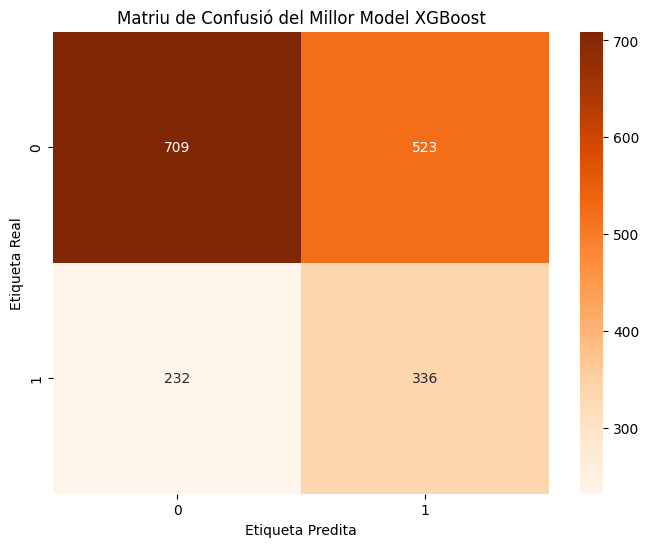

In [ ]:
cm_xgb = confusion_matrix(y_test_xgb, y_pred_best_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=best_xgb.classes_, 
            yticklabels=best_xgb.classes_)  
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió del Millor Model XGBoost')
plt.show()

Visualitzem la corba ROC i l'AUC per avaluar el model.

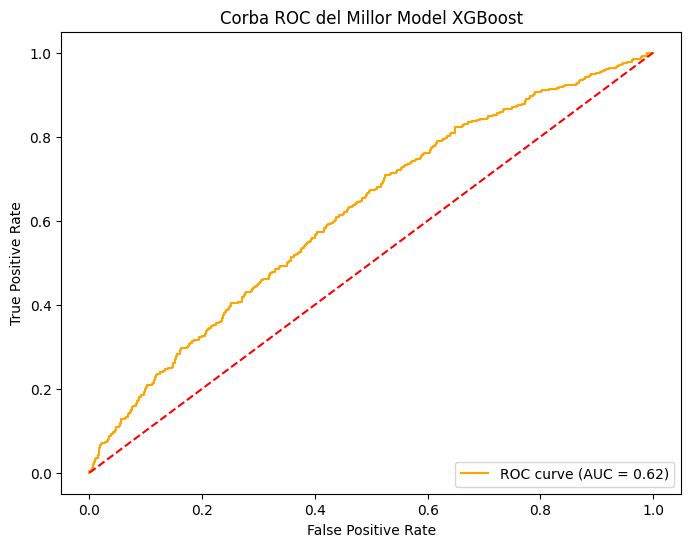

In [97]:
y_prob_best_xgb = best_xgb.predict_proba(X_test_xgb)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test_xgb, y_prob_best_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='orange', label=f'ROC curve (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Corba ROC del Millor Model XGBoost')
plt.legend(loc='lower right')
plt.show()

Mirem les corbes d'aprenentatge per detectar overfitting o underfitting.

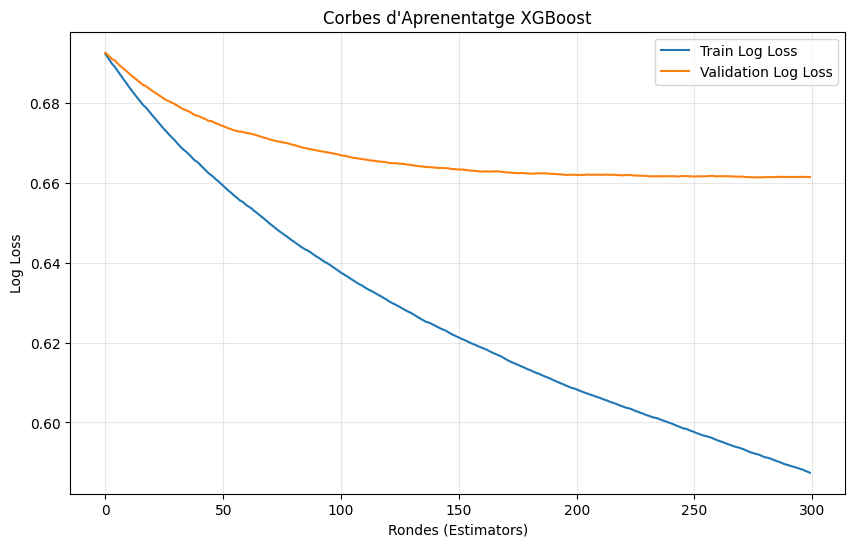

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt


model_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1,
    **grid_xgb.best_params_  
)

eval_set = [
    (X_train_xgb, y_train_xgb),  
    (X_test_xgb, y_test_xgb)   
]

model_xgb.fit(
    X_train_xgb, y_train_xgb,
    eval_set=eval_set, 
    verbose=False,           
)

results = model_xgb.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train Log Loss', color='#1f77b4') # Blau
plt.plot(x_axis, results['validation_1']['logloss'], label='Validation Log Loss', color='#ff7f0e') # Taronja

plt.legend()
plt.xlabel('Rondes (Estimators)')
plt.ylabel('Log Loss')
plt.title("Corbes d'Aprenentatge XGBoost")
plt.grid(True, alpha=0.3)
plt.show()


## 2.3 Per a Regressió Logística personalitzada

1. Particionar


In [37]:
df = pd.read_csv('trs_train.csv')

X = df.drop('TRS', axis=1)
y = df['TRS']

if 'patient_id' in X.columns:
    X = X.drop('patient_id', axis=1)

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

També eliminem les variables molt correlacionades (correlació > 0.5):

In [38]:
# eliminem: Triglycerides, Glucose, Ki_associative_striatum, SUVRc_whole_striatum, SUVRc_associative_striatum
cols_to_remove = [
    'Triglycerides', 'Glucose', 
    'Ki_associative_striatum', 
    'SUVRc_whole_striatum', 
    'SUVRc_associative_striatum'
]
X_train_lr = X_train_lr.drop(columns=cols_to_remove, errors='ignore')
X_test_lr = X_test_lr.drop(columns=cols_to_remove, errors='ignore')

2. Codificació de variables categòriques amb One-Hot Encoding

In [39]:
cat_cols = X_train_lr.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train_lr.select_dtypes(exclude=['object']).columns.tolist()

ohe_lr = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
ohe_lr.fit(X_train_lr[cat_cols])

X_train_cat = ohe_lr.transform(X_train_lr[cat_cols])
X_test_cat = ohe_lr.transform(X_test_lr[cat_cols])

new_names = ohe_lr.get_feature_names_out(cat_cols)
X_train_cat_df = pd.DataFrame(X_train_cat, columns=new_names, index=X_train_lr.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=new_names, index=X_test_lr.index)

X_train_lr = pd.concat([X_train_lr[num_cols], X_train_cat_df], axis=1)
X_test_lr = pd.concat([X_test_lr[num_cols], X_test_cat_df], axis=1)

3. Imputació de valors faltants amb KNNImputer amb ``k=5``

In [40]:
scaler_temp_lr = StandardScaler()
X_train_scaled_temp = scaler_temp_lr.fit_transform(X_train_lr)
X_test_scaled_temp = scaler_temp_lr.transform(X_test_lr)

knn_lr = KNNImputer(n_neighbors=5)
X_train_imputed_vals = knn_lr.fit_transform(X_train_scaled_temp)
X_test_imputed_vals = knn_lr.transform(X_test_scaled_temp)

X_train_lr = pd.DataFrame(scaler_temp_lr.inverse_transform(X_train_imputed_vals), 
                          columns=X_train_lr.columns, index=X_train_lr.index)
X_test_lr = pd.DataFrame(scaler_temp_lr.inverse_transform(X_test_imputed_vals), 
                         columns=X_test_lr.columns, index=X_test_lr.index)


4. Transformació de variables numèriques per reduir skewness amb PowerTransformer. Farem la transformació Yeo-Johnson perquè és més robusta

In [42]:
pt_lr = PowerTransformer(method='yeo-johnson', standardize=False)
cols_skewed = ['Duration_untreated_psychosis', 'Age']

pt_lr.fit(X_train_lr[cols_skewed])

X_train_lr[cols_skewed] = pt_lr.transform(X_train_lr[cols_skewed])
X_test_lr[cols_skewed] = pt_lr.transform(X_test_lr[cols_skewed])

5. Escalat de les variables numèriques amb StandardScaler

In [43]:
scaler_final_lr = StandardScaler()

X_train_lr_final = scaler_final_lr.fit_transform(X_train_lr)
X_test_lr_final = scaler_final_lr.transform(X_test_lr)

6. Model de Regressió Logística personalitzada 

In [ ]:
class CustomLogisticRegression:
    """
    Regressió Logística personalitzada amb Mini-Batch Gradient Descent.
    
    Implementació estil scikit-learn amb suport per:
    - Mini-batch gradient descent
    - Regularització L1 (Lasso) i L2 (Ridge)
    - Pesos de classe per a datasets desbalancejats
    - Early stopping
    
    Parameters
    ----------
    learning_rate : float, default=0.01
        Taxa d'aprenentatge per al gradient descent.
    n_iterations : int, default=1000
        Nombre màxim d'iteracions (èpoques).
    batch_size : int, default=32
        Mida del mini-batch.
    regularization : str, default='l2'
        Tipus de regularització: 'l1', 'l2' o None.
    lambda_reg : float, default=0.01
        Força de la regularització.
    class_weight : str or dict, default=None
        'balanced' per calcular pesos automàticament, o dict {class: weight}.
    tol : float, default=1e-4
        Tolerància per a early stopping.
    patience : int, default=10
        Nombre d'èpoques sense millora abans d'aturar.
    random_state : int, default=None
        Llavor per a reproductibilitat.
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, batch_size=32,
                 regularization='l2', lambda_reg=0.01, class_weight=None,
                 tol=1e-4, patience=10, random_state=None, verbose=False):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.regularization = regularization
        self.lambda_reg = lambda_reg
        self.class_weight = class_weight
        self.tol = tol
        self.patience = patience
        self.random_state = random_state
        self.verbose = False 

        # els apren durant l'entrenament
        self.weights_ = None
        self.bias_ = None
        self.loss_history = []
        self.classes_ = None
        
    def _sigmoid(self, z):
        """Funció sigmoide amb clipping per evitar overflow."""
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def _compute_class_weights(self, y):
        """Calcula els pesos de classe si class_weight='balanced'."""

        #si el pes de classe no està definit, retornem pesos iguals
        if self.class_weight is None:
            return np.ones(len(y))
        
        # si és 'balanced', calculem pesos inversament proporcionals a la freqüència
        elif self.class_weight == 'balanced':
            classes, counts = np.unique(y, return_counts=True)
            n_samples = len(y)
            n_classes = len(classes)
            weights_dict = {c: n_samples / (n_classes * count) 
                           for c, count in zip(classes, counts)}
            return np.array([weights_dict[yi] for yi in y])
        
        # si és un diccionari, utilitzem els pesos donats 
        elif isinstance(self.class_weight, dict):
            return np.array([self.class_weight.get(yi, 1.0) for yi in y])
        
        # si no és cap dels anteriors, retornem pesos iguals
        else:
            return np.ones(len(y))
    
    def _compute_loss(self, y_true, y_pred, sample_weights):
        """Calcula la Binary Cross-Entropy Loss amb regularització."""

        # clipping per evitar log(0)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # loss bce ponderada
        bce = -np.mean(sample_weights * (y_true * np.log(y_pred) + 
                                          (1 - y_true) * np.log(1 - y_pred)))
        
        # regularització
        if self.regularization == 'l2':
            reg_term = (self.lambda_reg / 2) * np.sum(self.weights_ ** 2)
        elif self.regularization == 'l1':
            reg_term = self.lambda_reg * np.sum(np.abs(self.weights_))
        else:
            reg_term = 0
            
        return bce + reg_term
    
    def _compute_gradients(self, X_batch, y_batch, y_pred, sample_weights):
        """Calcula els gradients per als pesos i el biaix."""
        n_samples = X_batch.shape[0]
        
        # error ponderat
        error = (y_pred - y_batch) * sample_weights
        
        # gradient dels pesos
        dw = (1 / n_samples) * np.dot(X_batch.T, error)
        
        # regularització
        if self.regularization == 'l2':
            dw += self.lambda_reg * self.weights_
        elif self.regularization == 'l1':
            dw += self.lambda_reg * np.sign(self.weights_)
        
        # gradient biaix
        db = (1 / n_samples) * np.sum(error)
        
        return dw, db
    
    def fit(self, X, y):
        """
        Entrena el model amb Stratified Mini-Batch Gradient Descent.
        """
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        
        # inicialització de pesos
        limit = 1 / np.sqrt(n_features)
        self.weights_ = np.random.uniform(-limit, limit, n_features)
        self.bias_ = 0.0
        
        # pesos de classe per a la funció de pèrdua
        sample_weights_total = self._compute_class_weights(y)
        
        # separem les classes per a l'stratified batching
        idx_class_0 = np.where(y == 0)[0]
        idx_class_1 = np.where(y == 1)[0]
        
        # quantitat de mostres per classe en cada batch
        prop_class_1 = len(idx_class_1) / n_samples
        batch_size_1 = max(1, int(self.batch_size * prop_class_1))
        batch_size_0 = self.batch_size - batch_size_1

        self.loss_history = []
        best_loss, patience_counter = np.inf, 0
        best_weights, best_bias = None, None
        
        for epoch in range(self.n_iterations):
            # barregem els índexs de cada classe
            np.random.shuffle(idx_class_0)
            np.random.shuffle(idx_class_1)
            
            # iterar sobre el nombre de batches
            n_batches = n_samples // self.batch_size
            
            for i in range(n_batches):
                # seleccionem índexs de forma cíclica per a cada classe
                start_0, end_0 = (i * batch_size_0) % len(idx_class_0), ((i + 1) * batch_size_0) % len(idx_class_0)
                start_1, end_1 = (i * batch_size_1) % len(idx_class_1), ((i + 1) * batch_size_1) % len(idx_class_1)
                
                # per si l'index final és menor que l'inicial (cicle)
                if end_0 <= start_0: 
                    batch_idx_0 = idx_class_0[start_0:] 
                else: 
                    batch_idx_0 = idx_class_0[start_0:end_0]
                    
                if end_1 <= start_1: 
                    batch_idx_1 = idx_class_1[start_1:]
                else: 
                    batch_idx_1 = idx_class_1[start_1:end_1]
                
                batch_indices = np.concatenate([batch_idx_0, batch_idx_1])
                
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]
                weights_batch = sample_weights_total[batch_indices]
                
                # predicció i gradients
                z = np.dot(X_batch, self.weights_) + self.bias_ # z = x · w + b
                y_pred = self._sigmoid(z) # aplicació sigmoide
                dw, db = self._compute_gradients(X_batch, y_batch, y_pred, weights_batch)
    
                # actualització
                self.weights_ -= self.learning_rate * dw
                self.bias_ -= self.learning_rate * db
            
            # early stopping check (pèrdua global)
            z_full = np.dot(X, self.weights_) + self.bias_
            current_loss = self._compute_loss(y, self._sigmoid(z_full), sample_weights_total)
            self.loss_history.append(current_loss)
            
            if current_loss < best_loss - self.tol:
                best_loss, best_weights, best_bias, patience_counter = current_loss, self.weights_.copy(), self.bias_, 0
            else:
                patience_counter += 1
            
            if patience_counter >= self.patience: break
            
        if best_weights is not None:
            self.weights_, self.bias_ = best_weights, best_bias
            
        return self


    def predict_proba(self, X):
        """
        Retorna les probabilitats predites per cada classe.
        
        Parameters
        ----------
        X : array-like de forma (n_samples, n_features)
            Mostres per predir.
            
        Returns
        -------
        proba : array de forma (n_samples, 2)
            Probabilitats per a classe 0 i classe 1.
        """
        X = np.array(X)
        z = np.dot(X, self.weights_) + self.bias_
        prob_class_1 = self._sigmoid(z)
        prob_class_0 = 1 - prob_class_1
        return np.column_stack([prob_class_0, prob_class_1])
    
    def predict(self, X, threshold=0.5):
        """
        Prediu les etiquetes de classe.
        
        Parameters
        ----------
        X : array-like de forma (n_samples, n_features)
            Mostres per predir.
        threshold : float, default=0.5
            Llindar de decisió.
            
        Returns
        -------
        y_pred : array de forma (n_samples,)
            Etiquetes predites.
        """
        proba = self.predict_proba(X)[:, 1]
        return (proba >= threshold).astype(int)

    
    def get_params(self, deep=True):
        """Retorna els paràmetres del model"""
        return {
            'learning_rate': self.learning_rate,
            'n_iterations': self.n_iterations,
            'batch_size': self.batch_size,
            'regularization': self.regularization,
            'lambda_reg': self.lambda_reg,
            'class_weight': self.class_weight,
            'tol': self.tol,
            'patience': self.patience,
            'random_state': self.random_state,
            'verbose': self.verbose
        }
    
    def set_params(self, **params):
        """Estableix els paràmetres del model"""
        for key, value in params.items():
            setattr(self, key, value)
        return self


In [41]:
# ajustem models amb Grid Search
param_grid_lr = {
    'learning_rate': [0.0001, 0.005, 0.01, 0.05, 0.1],
    'batch_size': [16, 32, 64, 128],
    'n_iterations': [100, 300, 500, 700, 900],
    'regularization': ['l1', 'l2', None],
    'lambda_reg': [0.01, 0.05, 0.1, 0.5, 1.0],
    'class_weight': ['balanced', {0: 1, 1: 2}],
}

logreg_base = CustomLogisticRegression(random_state=42, patience=15, tol=1e-4)
grid_search_lr = GridSearchCV(
    estimator=logreg_base,
    param_grid=param_grid_lr,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

print("Iniciant Grid Search per Regressió Logística...")

grid_search_lr.fit(X_train_lr_final, y_train_lr)
print("\n" + "="*50)
print(f"MILLORS PARÀMETRES: {grid_search_lr.best_params_}")
print(f"MILLOR SCORE (CV): {grid_search_lr.best_score_:.4f}")
print("="*50)
# Avaluar al Test Set
best_lr = grid_search_lr.best_estimator_
y_pred_best_lr = best_lr.predict(X_test_lr_final)
print("\n--- RESULTATS MILLOR LOGREG (TEST SET) ---")
print(classification_report(y_test_lr, y_pred_best_lr))

Iniciant Grid Search per Regressió Logística...
Fitting 5 folds for each of 2400 candidates, totalling 12000 fits

MILLORS PARÀMETRES: {'batch_size': 128, 'class_weight': {0: 1, 1: 2}, 'lambda_reg': 1.0, 'learning_rate': 0.0001, 'n_iterations': 500, 'regularization': 'l2'}
MILLOR SCORE (CV): 0.5946

--- RESULTATS MILLOR LOGREG (TEST SET) ---
              precision    recall  f1-score   support

           0       0.74      0.67      0.70      1232
           1       0.40      0.49      0.44       568

    accuracy                           0.61      1800
   macro avg       0.57      0.58      0.57      1800
weighted avg       0.63      0.61      0.62      1800



Estudi del millor model en funció de la mida del batch:

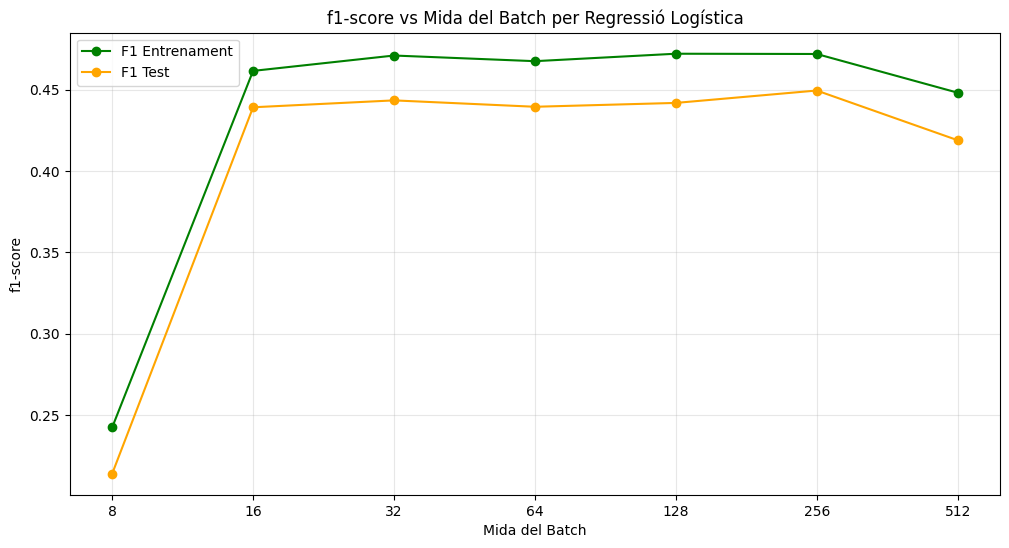

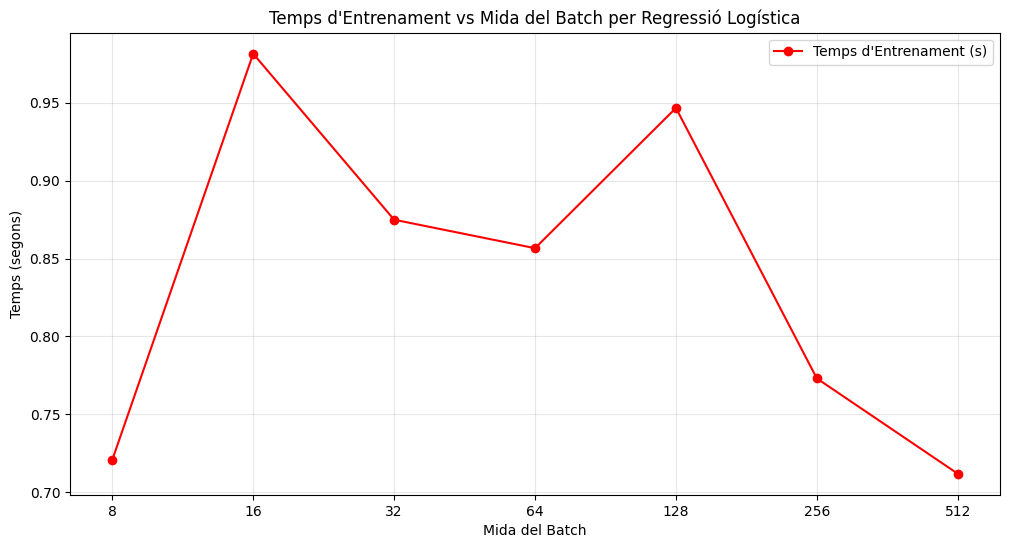

In [83]:
import time
#mirem batch de 8 a 512
batch_sizes = [8, 16, 32, 64, 128, 256, 512]
train_f1s = []
test_f1s = []
times_elapsed = []
for batch_size in batch_sizes:
    model_lr = CustomLogisticRegression(
        learning_rate=0.0001,
        n_iterations=500,
        batch_size=batch_size,
        regularization='l2',
        lambda_reg=1.0,
        class_weight={0: 1, 1: 2},
        random_state=42
    )
    
    start_time = time.time()
    model_lr.fit(X_train_lr_final, y_train_lr)
    end_time = time.time()
    
    # calculem f1-score
    y_train_pred = model_lr.predict(X_train_lr_final)
    y_test_pred = model_lr.predict(X_test_lr_final)
    train_f1 = f1_score(y_train_lr, y_train_pred)
    test_f1 = f1_score(y_test_lr, y_test_pred)
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)

    times_elapsed.append(end_time - start_time)
    
# graficar resultats
plt.figure(figsize=(12, 6))
plt.plot(batch_sizes, train_f1s, '-o', label='F1 Entrenament', color='green')
plt.plot(batch_sizes, test_f1s, '-o', label='F1 Test', color='orange')
plt.xlabel('Mida del Batch')
plt.ylabel('f1-score')
plt.title('f1-score vs Mida del Batch per Regressió Logística')
plt.xscale('log', base=2)
plt.xticks(batch_sizes, batch_sizes)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
# graficar temps d'entrenament
plt.figure(figsize=(12, 6))
plt.plot(batch_sizes, times_elapsed, '-o', label='Temps d\'Entrenament (s)', color='red')
plt.xlabel('Mida del Batch')
plt.ylabel('Temps (segons)')
plt.title('Temps d\'Entrenament vs Mida del Batch per Regressió Logística')
plt.xscale('log', base=2)
plt.xticks(batch_sizes, batch_sizes)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()



Ajustem el millor model

In [ ]:
best_lr = CustomLogisticRegression(
    learning_rate=0.01,
    n_iterations=500,
    batch_size=32,
    regularization='l2',
    lambda_reg=0.5,
    class_weight={0: 1, 1: 2},
    random_state=42
)
best_lr.fit(X_train_lr_final, y_train_lr)
y_pred_best_lr = best_lr.predict(X_test_lr_final)

print(classification_report(y_test_lr, y_pred_best_lr))

              precision    recall  f1-score   support

           0       0.75      0.67      0.71      1232
           1       0.42      0.52      0.46       568

    accuracy                           0.62      1800
   macro avg       0.59      0.59      0.59      1800
weighted avg       0.65      0.62      0.63      1800



Mirem matriu de confusió i corba ROC del millor model:

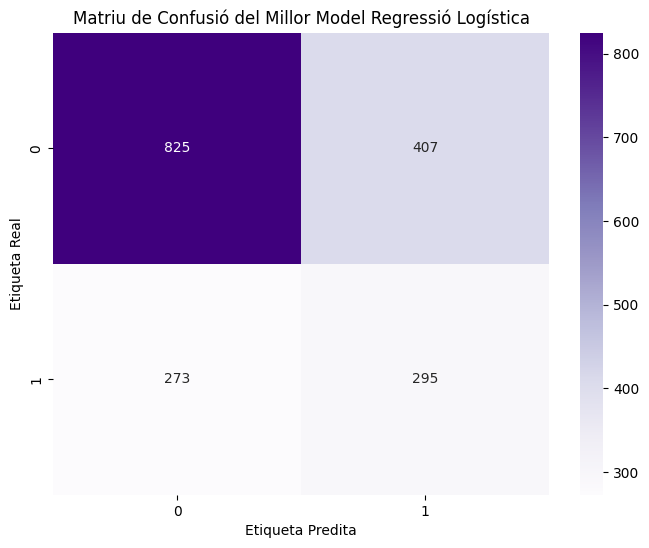

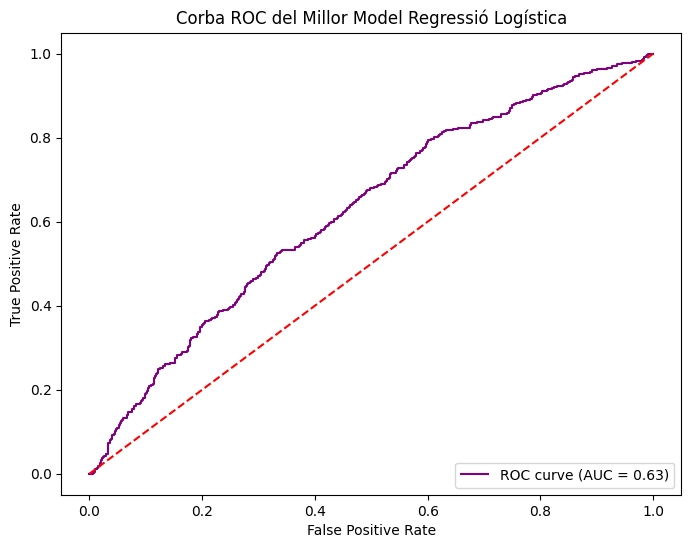

In [ ]:
cm_lr = confusion_matrix(y_test_lr, y_pred_best_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Purples', 
            xticklabels=best_lr.classes_, 
            yticklabels=best_lr.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió del Millor Model Regressió Logística')
plt.show()
# Corba ROC i AUC
y_prob_best_lr = best_lr.predict_proba(X_test_lr_final)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_lr, y_prob_best_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(8, 6))  
plt.plot(fpr_lr, tpr_lr, color='purple', label=f'ROC curve (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Corba ROC del Millor Model Regressió Logística')
plt.legend(loc='lower right')
plt.show()

Mètriques d'avaulació en funcio del llindar de decisió:

Text(0.5, 1.0, "Mètriques d'Avaluació en Funció del Llindar de Decisió")

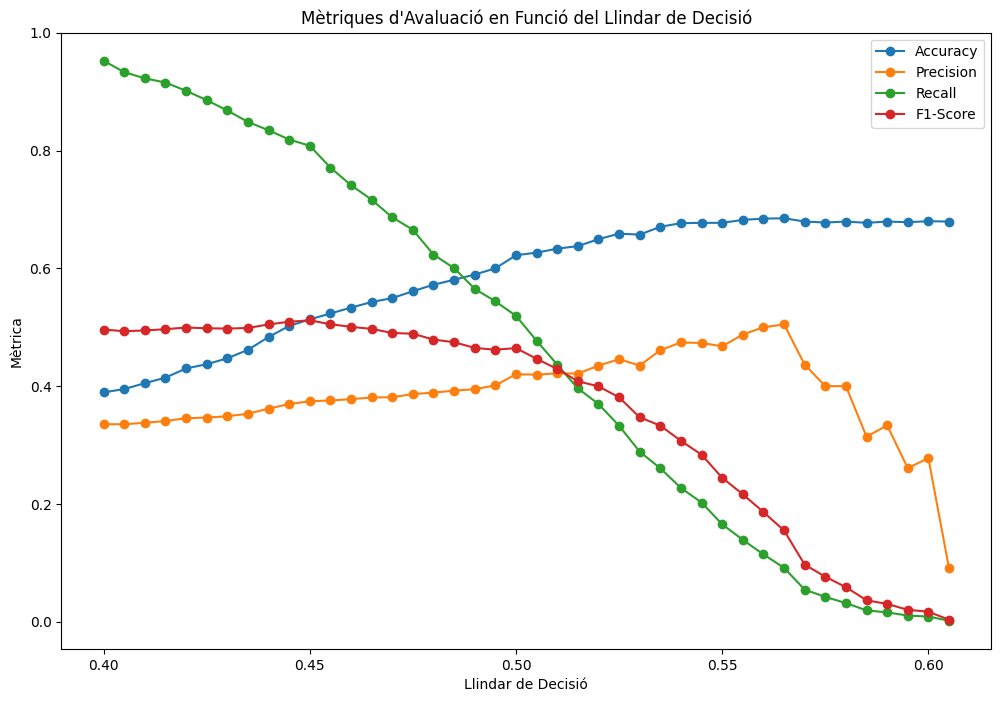

In [ ]:
thresholds = np.arange(0.4, 0.61, 0.005)
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
for thresh in thresholds:
    y_pred_thresh = (y_prob_best_lr >= thresh).astype(int)
    accuracy_scores.append(accuracy_score(y_test_lr, y_pred_thresh))
    precision_scores.append(precision_score(y_test_lr, y_pred_thresh))
    recall_scores.append(recall_score(y_test_lr, y_pred_thresh))
    f1_scores.append(f1_score(y_test_lr, y_pred_thresh))
plt.figure(figsize=(12, 8))
plt.plot(thresholds, accuracy_scores, label='Accuracy', marker='o')
plt.plot(thresholds, precision_scores, label='Precision', marker='o')
plt.plot(thresholds, recall_scores, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1-Score', marker='o')
plt.xlabel('Llindar de Decisió')
plt.ylabel('Mètrica')
plt.legend()
plt.title('Mètriques d\'Avaluació en Funció del Llindar de Decisió')


Corba Precisión-Recall:

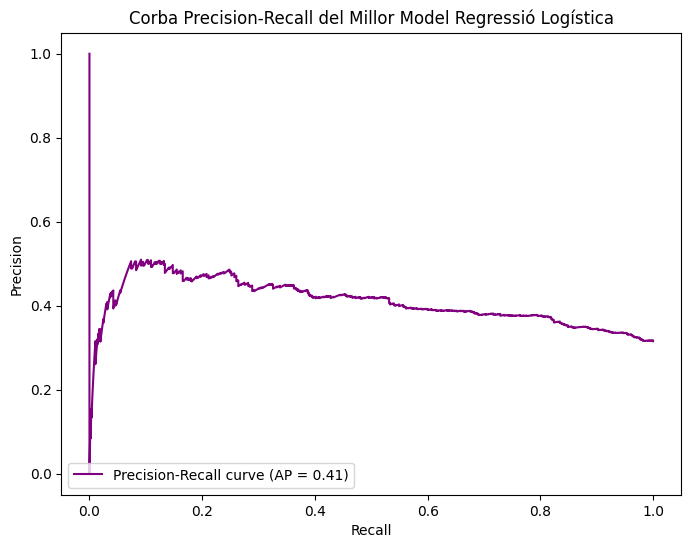

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
precision_lr, recall_lr, _ = precision_recall_curve(y_test_lr, y_prob_best_lr)
avg_precision_lr = average_precision_score(y_test_lr, y_prob_best_lr)
plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, color='purple', label=f'Precision-Recall curve (AP = {avg_precision_lr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Corba Precision-Recall del Millor Model Regressió Logística')
plt.legend(loc='lower left')
plt.show()


Mirem els pesos més importants del model

C:\Users\User\AppData\Local\Temp\ipykernel_16668\17940447.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(20), palette='viridis')


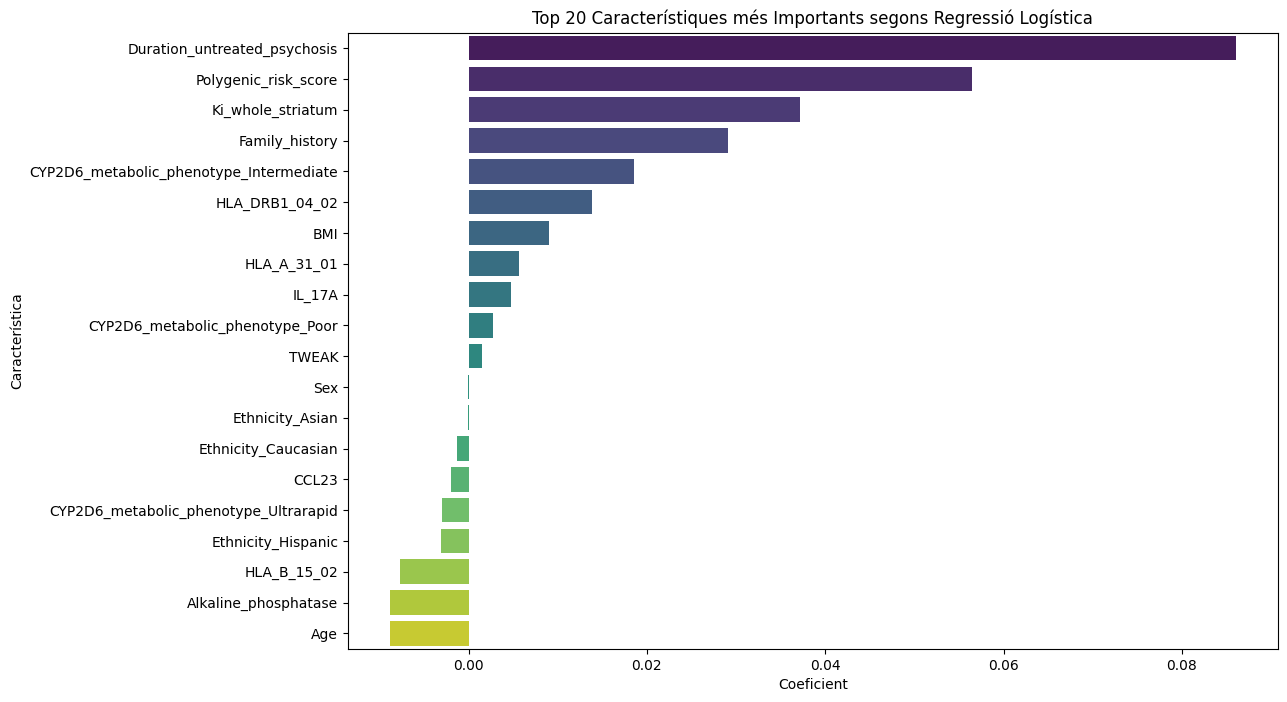

In [106]:
# pesos del model
feature_names_lr = X_train_lr.columns
coeficients = best_lr.weights_
coef_df = pd.DataFrame({
    'Feature': feature_names_lr,
    'Coefficient': coeficients
})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(20), palette='viridis')
plt.title('Top 20 Característiques més Importants segons Regressió Logística')
plt.xlabel('Coeficient')
plt.ylabel('Característica')
plt.show()


### 2.4 Per a Explanable Boosting Machine (EBM)

1. Particionar

In [ ]:
df = pd.read_csv('trs_train.csv')
X = df.drop('TRS', axis=1)
y = df['TRS']
X = X.drop('patient_id', axis=1)

X_train_ebm, X_test_ebm, y_train_ebm, y_test_ebm = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify =  y
)


Fem una graella per trobar els millors hiperparàmetres per al model EBM

In [ ]:
from sklearn.model_selection import GridSearchCV
from interpret.glassbox import ExplainableBoostingClassifier

class_weights = np.sum(y_train_ebm == 0) / np.sum(y_train_ebm == 1)

weights = {0: 1.0,
    1: class_weights  # augmentem el pes de la classe minoritària
}


param_grid = {
    'learning_rate': [0.01, 0.02, 0.05],       
    'max_leaves': [3, 5, 7],                    
}

ebm = ExplainableBoostingClassifier(n_jobs=-1, random_state=42, outer_bags=8, inner_bags=0, max_bins=64, reg_alpha=0.1, reg_lambda=0.1, early_stopping_rounds=20)

grid_search = GridSearchCV(
    ebm, 
    param_grid, 
    scoring='f1_macro', 
    n_jobs=-1,
    cv=3,
    verbose=1
)

grid_search.fit(X_train_ebm, y_train_ebm, sample_weight=y_train_ebm.map(weights))  

print(f"Millors paràmetres: {grid_search.best_params_}")
print(classification_report(y_test_ebm, grid_search.best_estimator_.predict(X_test_ebm)))


Ajustem el millor model amb els hiperparàmetres trobats

In [7]:
class_weights = np.sum(y_train_ebm == 0) / np.sum(y_train_ebm == 1)

weights = {0: 1.0,
    1: class_weights  # augmentem el pes de la classe minoritària
}
best_ebm = ExplainableBoostingClassifier(
    max_leaves=3,
    learning_rate=0.05,
    max_bins=64,
    outer_bags=8,
    inner_bags=0,
    reg_alpha=0.1,
    reg_lambda=0.1,
    early_stopping_rounds=20,
    n_jobs=-1,
    random_state=42,
)
best_ebm.fit(X_train_ebm, y_train_ebm, sample_weight=y_train_ebm.map(weights))

c:\Users\User\Documents\universitat\2n1q\iaa\practica\clinical-trs-prediction\venv\Lib\site-packages\interpret\glassbox\_ebm\_ebm.py:871: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]
  warn(


,feature_names,None
,feature_types,None
,max_bins,64
,max_interaction_bins,64
,interactions,'3x'
,exclude,None
,validation_size,0.15
,outer_bags,8
,inner_bags,0
,learning_rate,0.05
,greedy_ratio,10.0


Ana

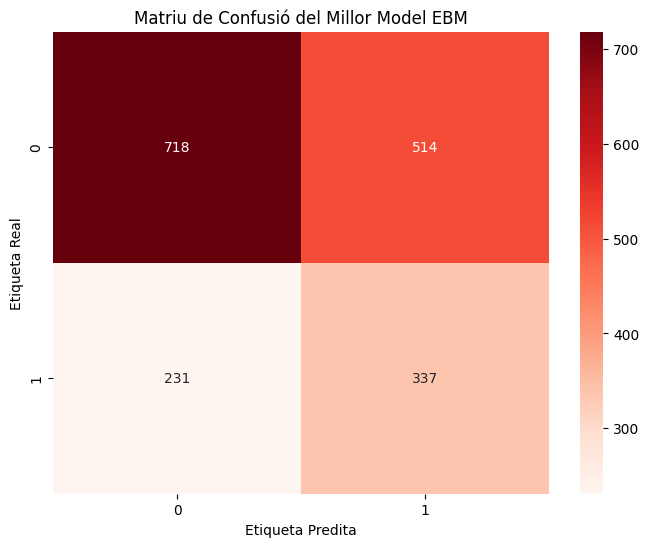

In [8]:
y_pred_best_ebm = best_ebm.predict(X_test_ebm)
cm_best_ebm = confusion_matrix(y_test_ebm, y_pred_best_ebm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_ebm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=best_ebm.classes_, 
            yticklabels=best_ebm.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió del Millor Model EBM')
plt.show()

Corba ROC i AUC del model EBM

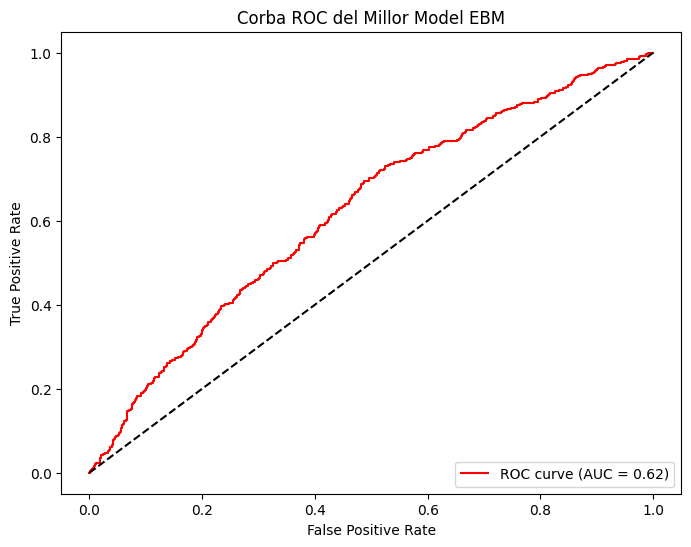

In [9]:
y_prob_best_ebm = best_ebm.predict_proba(X_test_ebm)[:, 1]
fpr_ebm, tpr_ebm, thresholds_ebm = roc_curve(y_test_ebm, y_prob_best_ebm)
roc_auc_ebm = auc(fpr_ebm, tpr_ebm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_ebm, tpr_ebm, color='red', label=f'ROC curve (AUC = {roc_auc_ebm:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Corba ROC del Millor Model EBM')
plt.legend(loc='lower right')
plt.show()


Valors ROC-AUC de la millor EBM al conjunt d'entrenament i de prova

In [ ]:
auc_train = roc_auc_score(y_train_ebm, best_ebm.predict_proba(X_train_ebm)[:, 1])
auc_test = roc_auc_score(y_test_ebm, best_ebm.predict_proba(X_test_ebm)[:, 1])

print(f"AUC Train: {auc_train:.4f}")
print(f"AUC Test: {auc_test:.4f}")
print(f"Diferència: {auc_train - auc_test:.4f}")


AUC Train: 0.6950
AUC Test: 0.6232
Diferència: 0.0719


Observem els gràfics d'importància de les característiques

In [ ]:
from interpret import show
ebm_global = best_ebm.explain_global(name='EBM')
show(ebm_global)


<!-- http://127.0.0.1:7001/2470711637872/ -->

Fem una submission amb el model entrenat

In [10]:
df_eval_ebm = pd.read_csv('trs_eval.csv')
eval_ids_ebm = df_eval_ebm['patient_id']
X_eval_ebm = df_eval_ebm.drop('patient_id', axis=1) if 'patient_id' in df_eval_ebm.columns else df_eval_ebm.copy()
final_predictions_ebm = best_ebm.predict(X_eval_ebm)
submission_ebm = pd.DataFrame({
    'patient_id': eval_ids_ebm,
    'TRS': final_predictions_ebm
})
submission_ebm.to_csv('submission_ebm.csv', index=False)

## 3. Model Card pel model EBM 

In [41]:

mct = ModelCardToolkit(output_dir='model_card_output', file_name='TRS_Prediction_SVM_RBF')
model_card = mct.scaffold_assets()

model_card.model_details.name = 'SVM RBF per Predicció de Resistència al Tractament (TRS)'
model_card.model_details.overview = (
    'Model predictiu basat en Support Vector Machine (SVM) amb kernel RBF dissenyat per identificar '
    'pacients amb esquizofrènia que presenten resistència al tractament antipsicòtic estàndard. '
    'El model prioritza la sensibilitat per actuar com una eina de cribratge en la decisió clínica.'
)
model_card.model_details.owners = [
    mctlib.Owner(name='Ferran Òdena Bernadí', contact='ferran.odena@estudiantat.upc.edu')
]
model_card.model_details.version.name = 'v1.1'
model_card.model_details.references = [
    mctlib.Reference(reference='Dades del projecte IAA 2025/26'),
    mctlib.Reference(reference='https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html (SVM documentation)')
]

# paràmetres
model_card.model_parameters.model_architecture = 'Support Vector Machine (SVM) amb kernel RBF'

# si no hi ha dades afegim una entrada buida
if not model_card.model_parameters.data:
    model_card.model_parameters.data.append(mctlib.Dataset())

model_card.model_parameters.input_format = (
    'Hiperparàmetres Clau: '
    'Kernel = RBF, '
    'C = 0.1, '
    'Gamma = auto, '
    'Class Weight = balanced.'
)

# dades (ajustat a les teves variables de l'SVM)
model_card.model_parameters.data[0].name = 'TRS Dataset (Clinical + Genetic)'
model_card.model_parameters.data[0].description = (
    f'Entrenat amb dades clíniques i genètiques de pacients amb esquizofrènia. '
    'Inclou dades demogràfiques, clíniques, biomarcadors i marcadors genètics. '
    'Nota: Aquestes dades es consideren sensibles (informació mèdica).' 
)

# validació quantitativa (valors nous)
model_card.quantitative_analysis.performance_metrics = [
    mctlib.PerformanceMetric(type='Accuracy', value='0.56', description='Precisió global al conjunt de prova (Test Set).'),
    mctlib.PerformanceMetric(type='Recall (TRS)', value='0.63', description='Capacitat del model per detectar correctament els pacients resistents (Sensibilitat).'),
    mctlib.PerformanceMetric(type='Precision (TRS)', value='0.38', description='Proporció de prediccions "TRS" que són realment correctes.'),
    mctlib.PerformanceMetric(type='F1-Score (TRS)', value='0.48', description='Mitjana harmònica entre precisió i recall per a la classe minoritària.'),
    mctlib.PerformanceMetric(type='AUC - ROC', value='0.62', description='Capacitat de discriminació real entre les dues classes per sobre de l\'atzar.')
]

# imatges (figures 18 i 19 segons el teu nou informe)
model_card.quantitative_analysis.graphics.collection = [
     mctlib.Graphic(image="./images/181.png", name='Matriu de Confusió (Figura 18)'),
     mctlib.Graphic(image='./images/191.png', name='Corba ROC (Figura 19)')
]

# advertències i consideracions
model_card.considerations.use_cases = [
    mctlib.UseCase(description='RECOMANACIÓ: Utilitzar com a eina de cribratge (screening) per identificar pacients amb alt risc.'),
    mctlib.UseCase(description='ADVERTÈNCIA: Els resultats positius han de ser sempre validats per un especialista degut a la taxa de falsos positius.'),
    mctlib.UseCase(description='ADVERTÈNCIA: No utilitzar per a la presa de decisions automàtica sense supervisió humana.')
]

# limitacions
model_card.considerations.limitations = [
    mctlib.Limitation(description='COMPROMÍS PRECISIÓ-RECALL: El model sacrifica precisió global per garantir la detecció de la majoria de pacients TRS.'),
    mctlib.Limitation(description='SENSIBILITAT A L\'ESCALAT: Requereix un preprocessament (StandardScaler) rigorós per funcionar correctament.'),
    mctlib.Limitation(description='GENERALITZACIÓ: El rendiment pot variar segons les característiques demogràfiques de la població aplicat.')
]

# actualitzar i exportar
mct.update_model_card(model_card)
html_path = mct.export_format(output_file='model_card_svm.html')